# Mouse line analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

## Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime
import itertools
from matplotlib.ticker import ScalarFormatter
import matplotlib.colors as mcolors
from statannotations.Annotator import Annotator
import diptest
from scipy.stats import ttest_1samp, shapiro

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *
from parsers import extract_FOV_area

# Figures dictionary
figs = {}

## Parameters

### Input datasets and main processing parameters

In [3]:
# Processing parameters
analysis_type = 'main'  # Analysis type
mouseline = 'sst'  # mouse line
layer = None  # cortical layer
slack_notify = False
global_correction = GLOBAL_CORRECTION  # global stack correction method
kalman_gain = KALMAN_GAIN  # gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection

# Plotting parameters
xkeys_plt = [  # input parameters
    Label.P,
    Label.DC,
    Label.ISPTA
]
ykeys_plt = [  # plotting variables
    Label.DFF,
    Label.ZSCORE, 
    # Label.EVENT_RATE
]
plot_rasters = False  # whether to render raster plots of population activity, or not
plot_traces = True  # whether to render traces of population activity, or not

### Derived parameters

In [4]:
# If global correction is dictionary, extract line-specific method
if isinstance(global_correction, dict):
    global_correction = global_correction[mouseline]

# Get batch-related settings
dataset_group_id, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, mouseline, layer, global_correction, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_id = get_baseline_id(baseline_quantile, baseline_wquantile, baseline_wsmoothing)

ispv = mouseline == 'pv'
isnotpv = not ispv

# Set ON/OFF execution flags
skip_rasters = not plot_rasters
skip_traces = not plot_traces
 
# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{dataset_group_id} {analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/06/17 16:44:35: assembling batch analysis settings...
 2024/06/17 16:44:35: sst main analysis notebook started on 2024-06-17 at 16:44:35


### Input summary table figure

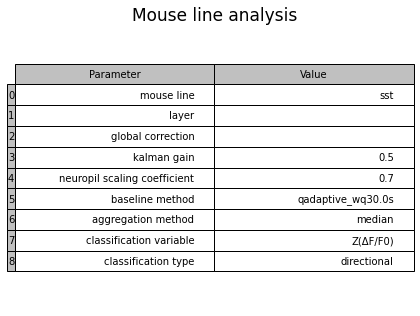

In [5]:
figs['dataset_info'] = plot_table({
    'mouse line': mouseline,
    'layer': layer,
    'global correction': global_correction,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline method': baseline_id,
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    }, title='Mouse line analysis', aspect=1.5)

## Load & inspect initial data

### Load data

In [6]:
# Determine exclude patterns
# from excludes import main_excludes
# exclude_patterns = list(set(main_excludes[mouseline]))
exclude_patterns = None

# Determine what to do in case of duplicate runs
on_duplicate_runs = 'drop'

# Load datasets
logger.info(f'loading data from {input_dir}:')
data = load_processed_datasets(
    input_dir, layer=layer,
    exclude_patterns=exclude_patterns,
    on_duplicate_runs=on_duplicate_runs)
logger.info('data successfully loaded.')

 2024/06/17 16:44:38: loading data from /gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/sst:
 2024/06/17 16:44:38: gathering dataset IDs...
 2024/06/17 16:44:39: loading mouse-region data from 20190510_mouse6_region1.h5
 2024/06/17 16:44:39: loading mouse-region data from 20190510_mouse6_region2.h5
 2024/06/17 16:44:40: loading mouse-region data from 20190511_mouse7_region1.h5
 2024/06/17 16:44:40: loading mouse-region data from 20190511_mouse7_region2.h5
 2024/06/17 16:44:40: loading mouse-region data from 20190513_mouse2_region1.h5
 2024/06/17 16:44:40: loading mouse-region data from 20190513_mouse2_region2.h5
 2024/06/17 16:44:40: loading mouse-region data from 20190514_mouse1_region1.h5
 2024/06/17 16:44:41: loading mouse-region data from 20190514_mouse1_region2.h5
 2024/06/17 16:44:41: loading mouse-region data from 20190516_mouse8_region1.h5

### Unpack data and get ROI counts

In [7]:
# Unpack
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, map_ops = extract_from_batch_data(data)

# # TEMPORARY FIX: Offset population-aggregated traces by their median values
# logger.warning('TEMP FIX: computing ΔF/F and z-score traces median values for each dataset & run...')
# ykeys_offset = [Label.DFF, Label.ZSCORE]
# ymeds = popagg_timeseries[ykeys_offset].groupby([Label.DATASET, Label.RUN]).median()
# logger.warning('TEMP FIX: offseting median values from traces...')
# popagg_timeseries[ykeys_offset] -= expand_to_match(ymeds, popagg_timeseries.index)

# Display ROI count per dataset & run, and highlight incomplete datasets
logger.info('detailed ROI count:')
get_detailed_ROI_count(trialagg_stats, style=True)

 2024/06/17 16:45:14: extracting timeseries and stats from data...
 2024/06/17 16:45:14: detailed ROI count:


run,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
P (MPa),0.00,0.05,0.10,0.20,0.40,0.60,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80,0.80
DC (%),50,50,50,50,50,50,05,10,20,30,40,50,60,70,80
dataset,,,,,,,,,,,,,,,
20190510_mouse6_region1,285,nan,nan,285,285,285,285,285,285,285,285,285,nan,nan,nan
20190510_mouse6_region2,295,nan,nan,295,295,295,295,295,295,295,295,295,nan,nan,nan
20190511_mouse7_region1,357,nan,nan,357,357,357,357,357,357,357,357,357,nan,nan,nan
20190511_mouse7_region2,397,nan,nan,397,397,397,397,397,397,397,397,397,nan,nan,nan
20190513_mouse2_region1,322,nan,nan,322,322,322,322,322,322,322,322,322,nan,nan,nan
20190513_mouse2_region2,367,nan,nan,367,367,367,367,367,367,367,367,367,nan,nan,nan
20190514_mouse1_region1,310,nan,nan,310,310,310,310,310,310,310,310,310,nan,nan,nan


### Inspect cell maps and exclude outlier datasets 

 2024/06/17 16:45:16: sorted cell densities:
dataset
20190628_mouse2_region1     598.444316
20190629_mouse3_region1     649.627054
20190510_mouse6_region1     793.432564
20190514_mouse1_region1     863.031911
20190513_mouse2_region1     896.439598
20190706_mouse7_region1     917.352142
20190808_mouse7_region2     921.289276
20190513_mouse2_region2    1021.718424
20190516_mouse8_region2    1030.070346
20190510_mouse6_region2    1161.454429
20190701_mouse1_region1    1204.762899
20190514_mouse1_region2    1303.191241
20190808_mouse8_region1    1381.933914
20190511_mouse7_region1    1405.556716
20190511_mouse7_region2    1563.042062
20190516_mouse8_region1    1637.847602
20190808_mouse6_region1    1681.156072
dtype: float64
 2024/06/17 16:45:16: plotting cell maps...


100%|██████████| 17/17 [00:00<00:00, 68.31it/s]

 2024/06/17 16:45:17: no exclusion criterion -> ignoring


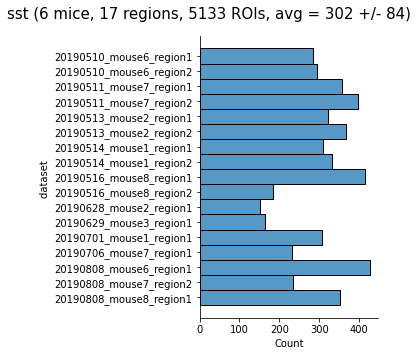

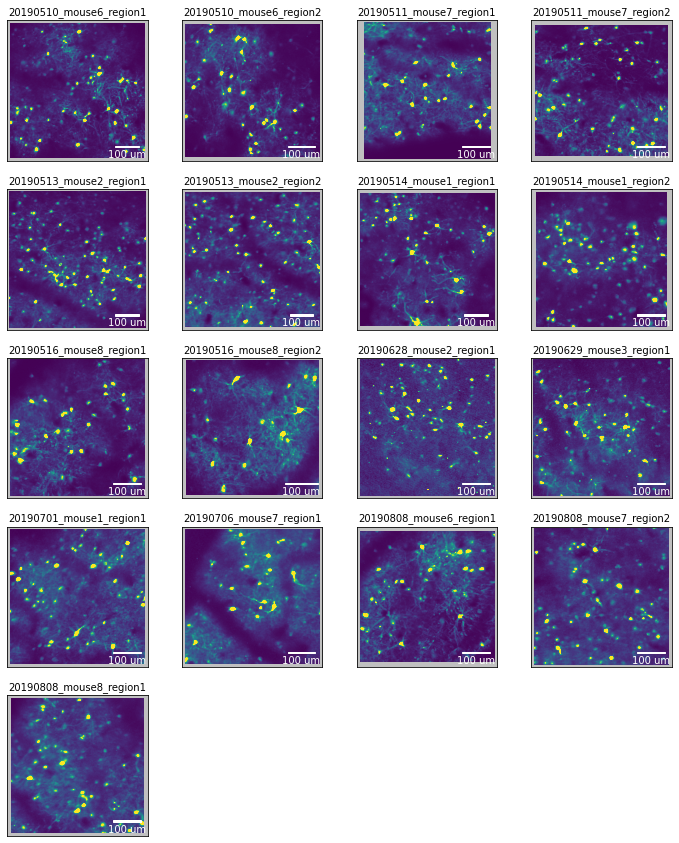

In [8]:
figs['cellcounts'] = plot_cellcounts(trialagg_stats, hue=None, title=mouseline)

# Compute ROI density for each dataset
FOV_areas = pd.Series({k: extract_FOV_area(v) for k, v in map_ops.items()})  # mm2
ROI_counts = get_detailed_ROI_count(trialagg_stats).max(axis=1).astype(int)  # cells
ROI_densities = ROI_counts / FOV_areas  # cells/mm2
logger.info(f'sorted cell densities:\n{ROI_densities.sort_values()}')

# If threshold on cell density is specified, exclude datasets with densities below threshold 
from constants import MIN_CELL_DENSITY
outliers = None
if MIN_CELL_DENSITY[mouseline] is not None:
    isoutlier = ROI_densities < MIN_CELL_DENSITY[mouseline]
    outliers = isoutlier[isoutlier].index.values.tolist()
    if len(outliers) > 0:
        logger.warning(f'datasets with abnormally low cell density::\n{pprint.pformat(outliers)}')
    figs['cellcounts'].axes[0].axvline(
        MIN_CELL_DENSITY[mouseline] * FOV_areas.mean(), c='k', ls='--')

# Plot cell maps and highlight outlier datasets
figs['cellmaps'] = plot_fields_of_view(
    map_ops, 
    refkey='max_proj',
    # ROI_masks=ROI_masks, 
    Fstats=trialagg_stats, 
    mode='contour', 
    hue=None, 
    outliers=outliers,
    qmax=.99
)

# Exclude outlier datasets
trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=outliers)

### Inspect baseline variation throughout experiments and exclude outlier datasets

 2024/06/17 16:45:19: inspecting relative variations in baseline fluorescence across experiments...
 2024/06/17 16:45:19: maximal relative FO deviations:
dataset
20190808_mouse6_region1    0.019267
20190628_mouse2_region1    0.022206
20190514_mouse1_region1    0.034105
20190808_mouse7_region2    0.036091
20190629_mouse3_region1    0.041770
20190706_mouse7_region1    0.049699
20190808_mouse8_region1    0.060001
20190511_mouse7_region1    0.075676
20190516_mouse8_region2    0.096444
20190516_mouse8_region1    0.098017
20190514_mouse1_region2    0.127294
20190510_mouse6_region2    0.132297
20190511_mouse7_region2    0.137575
20190513_mouse2_region1    0.140298
20190510_mouse6_region1    0.149265
20190513_mouse2_region2    0.156496
20190701_mouse1_region1    0.188215
Name: rel F0 (a.u.), dtype: float64


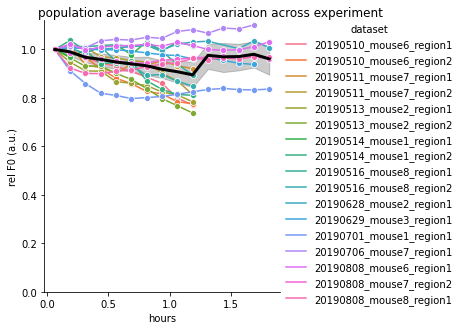

In [9]:
from constants import MAX_F0_REL_DEV
runid_maps = trialagg_stats[Label.RUNID].groupby([Label.DATASET, Label.RUN]).first()

def get_rel_F0(data, F0_key=Label.F0, aggbyrun=True):
    ''' Extract temporal evolution of F0 over experiment '''
    # Figure out dataset ID and associated run order
    dataset_id = data.index.unique(Label.DATASET)[0]
    # Extract frame rate from stats
    fps = get_singleton(trialagg_stats, Label.FPS)
    # Add time along entire experiment to population-average dataframe average
    idx = get_index_along_experiment(data.index, runid_map=runid_maps.loc[dataset_id])
    data[Label.TIME] = idx / fps
    # If specified, aggregate by run
    if aggbyrun:
        data = data.groupby(Label.RUN).median()
    # Compute relative variation from max
    yref = data.sort_values(Label.TIME)[F0_key].iloc[0]
    # yref = data[F0_key].max()
    relF0_key = f'rel {F0_key}'
    data[relF0_key] = data[F0_key] / yref
    # Return data of interest
    return data[[Label.TIME, relF0_key]]

# Compute relative variation of average baseline along experiment, for each dataset
logger.info('inspecting relative variations in baseline fluorescence across experiments...')
aggbyrun = True
F0_key = Label.F0
relF0_key = f'rel {F0_key}'
popagg_F0_per_run = (
    popagg_timeseries
    .groupby(Label.DATASET)
    .apply(lambda x: get_rel_F0(x, F0_key=F0_key, aggbyrun=aggbyrun))
)
popagg_F0_per_run[Label.HOURS] = popagg_F0_per_run[Label.TIME] / 3600

# Compute relative deviations of relative baseline fluorescence from its mean value,
# for each dataset
popagg_relF0_mean = popagg_F0_per_run[relF0_key].groupby(Label.DATASET).mean()
popagg_relF0_reldevs = ((popagg_F0_per_run[relF0_key] - popagg_relF0_mean) / popagg_relF0_mean).abs()

# Identify datasets that have at least 1 large F0 relative deviation from mean
max_popagg_relF0_reldevs = popagg_relF0_reldevs.groupby(Label.DATASET).max()
logger.info(f'maximal relative FO deviations:\n{max_popagg_relF0_reldevs.sort_values()}')
is_relF0_outlier = max_popagg_relF0_reldevs > MAX_F0_REL_DEV

# Extract datasets with at least 1 outlier run
relF0_outliers = is_relF0_outlier[is_relF0_outlier].index.unique(Label.DATASET).values.tolist()

# Remove potential outlier datasets
nouts = len(relF0_outliers)
palette = None
if nouts > 0:
    relF0_outliers_str = '\n'.join([f'  - {x}' for x in relF0_outliers])
    logger.warning(f'identified {nouts} datasets with abnormal baseline fluorescence variations:\n{relF0_outliers_str}')
    trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks = filter_datasets(
        trialagg_timeseries, popagg_timeseries, trialagg_stats, ext_stats, ROI_masks, exclude=relF0_outliers)
    palette = get_binary_palette(popagg_F0_per_run, relF0_outliers)

# Plot time evolution of average baseline along experiment, for each dataset
pltkwargs = dict(
    x=Label.HOURS,
    y=relF0_key,
)
fg = sns.relplot(
    kind='line',
    data=popagg_F0_per_run,
    errorbar=None, 
    hue=Label.DATASET,
    marker='o',
    palette=palette,
    legend=palette is None,
    aspect=1.,
    height=3 if not aggbyrun else 4.5,
    col=Label.DATASET if not aggbyrun else None,
    col_wrap=4 if not aggbyrun else None,
    **pltkwargs,
)
sns.despine(fig=fg.figure)
figs['popavg F0 across experiment'] = fg.figure
fg.figure.suptitle('population average baseline variation across experiment', y=1.01)
for ax in fg.figure.axes:
    # ax.axhline(1 - MAX_F0_REL_VAR, ls='--', c='k')
    ax.set_ylim(0, ax.get_ylim()[1])
if aggbyrun:
    # Add average trace across valid datasets
    sns.lineplot(
        ax=ax,
        data=popagg_F0_per_run.drop(relF0_outliers),
        lw=3, color='k', legend=False, **pltkwargs
    )

### Plot ROI / neuropil fluorescence ratio

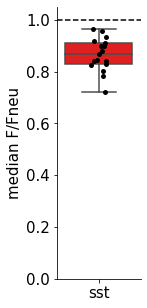

In [10]:
from plotters import plot_fluorescence_ratios
figs['F/Fneu'] = plot_fluorescence_ratios(popagg_timeseries, mouseline)

## Response curves

### Plot trial heatmap per condition for entire mouse line

In [11]:
%%skip $skip_rasters

sorted_ISPTAs = trialagg_stats[Label.ISPTA].groupby(Label.RUN).first().sort_values().apply(
    '{:.2f} W/cm2'.format)
fps = get_singleton(trialagg_stats, Label.FPS)

for ykey in ykeys_plt:
    figs[f'{ykey} heatmap'] = plot_activity_heatmap(
        trialagg_timeseries, ykey, fps, col=Label.RUN,
        col_order=sorted_ISPTAs.index.values, 
        col_labels=sorted_ISPTAs.values,
        rasterized=True,
        colwrap=len(sorted_ISPTAs), 
        sort_ROIs=True,
    )

### Visualize global average trace, along with impact of exclusion criteria (on population-aggregated data)

 2024/06/17 16:45:24: plotting % of excluded samples per dataset, across criteria
 2024/06/17 16:45:24: computing population average data across (dataset, run, trial)...
 2024/06/17 16:45:27: adding time info to table...
 2024/06/17 16:45:27: identifying conditions with >= 5 valid trials
 2024/06/17 16:45:27: adding expanded validity index to timeseries ...
 2024/06/17 16:45:27: filtering timeseries ...
 2024/06/17 16:45:28: identified 202/3232 (6.2%) samples with "discarded" tag
 2024/06/17 16:45:28: identifying conditions with >= 5 valid trials
 2024/06/17 16:45:28: adding expanded validity index to timeseries ...
 2024/06/17 16:45:28: filtering timeseries ...
 2024/06/17 16:45:28: identified 14/3232 (0.4%) samples with "motion" tag
 2024/06/17 16:45:28: identifying conditions with >= 5 valid trials
 2024/06/17 16:45:28: adding expanded validity index to timeseries ...
 2024/06/17 16:45:29: filtering timeseries ...
 2024/06/17 16:45:29: identified 0/3232 (0.0%) samples with "pre-stim

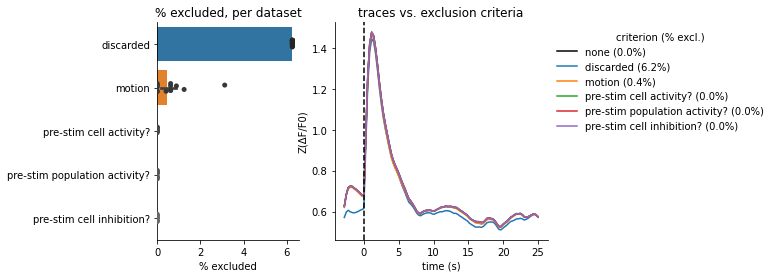

In [12]:
# Plot pct of exclusion per criterion and traces vs exclusion criteria
ykey = Label.ZSCORE
figs['impact of exclusion criteria'], axes = plt.subplots(
    1, 2, figsize=(7, 4), width_ratios=[1, 1.5])
plot_pct_excluded(ext_stats, ax=axes[0])
popagg_stats = get_popavg_data(ext_stats)
plot_traces_vs_exclusion(popagg_timeseries, popagg_stats, ykey, ax=axes[1]);

### Plot aggregate response trace for all non-zero conditions, and identify temporal response features and corresponding response analysis window

 2024/06/17 16:45:33: adding ['fps' 'duration (s)' 'P (MPa)' 'DC (%)' 'I_SPTA (W/cm2)'] information to timeseries...
 2024/06/17 16:45:47: adding time info to table...
 2024/06/17 16:45:49: plotting Z(ΔF/F0) response traces...
 2024/06/17 16:46:18: computing peak features on average trace...
 2024/06/17 16:46:18: response FWHM = 2.24s, corresponding window size = 2.25s (8 frames)
 2024/06/17 16:46:18: overwriting post window size in "/gpfs/scratch/lemait01/data/usnm/processed/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/sst/post_window_size.txt"


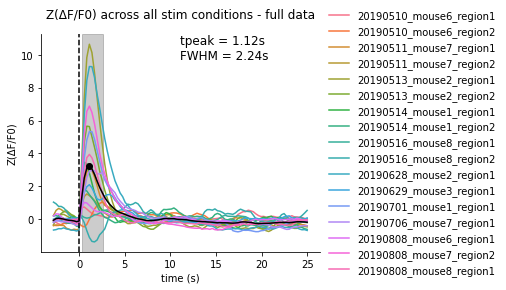

In [13]:
# Add critical stats columns to timeseries data
plt_data = get_plot_data(trialagg_timeseries, trialagg_stats)

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full' # 'grey'

# Extract plot data for all non-zero conditions
stim_cond = plt_data[Label.ISPTA] > 0
stim_pltdata = plt_data[stim_cond]

# Plot average trace across datasets
logger.info(f'plotting {ykey} response traces...')
figs[f'{ykey} resp trace merged'], ax = plt.subplots(figsize=(5, 4))
sns.despine(ax=ax)
if dataset_traces:
    sns.lineplot(
        ax=ax,
        data=stim_pltdata,
        x=Label.TIME,
        y=ykey,
        errorbar=None,
        hue=Label.DATASET,
        palette=get_uniform_palette(stim_pltdata) if dataset_traces == 'grey' else None,
        legend='full' if dataset_traces == 'full' else False,
    )
sns.lineplot(
    ax=ax,
    data=stim_pltdata,
    x=Label.TIME,
    y=ykey,
    errorbar='se',
    color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
)
ax.axvline(0, ls='--', c='k')
ax.set_title(f'{ykey} across all stim conditions - full data', y=1.05)

# Compute and materialize peak features on average trace
logger.info('computing peak features on average trace...')
fps = get_singleton(trialagg_stats, Label.FPS)
s = trialagg_timeseries[stim_cond][ykey].groupby(Label.FRAME).mean()
props = find_response_peak(
    s.loc[FrameIndex.STIM:], full_output=True, prominence=0.3 * np.ptp(s), width=1)
tprops = convert_peak_props(props, fps, ioffset=FrameIndex.STIM)
tpeak = tprops['index']  # s
ypeak = tprops['value']
FWHM = tprops['widths']  # s
ax.plot(tpeak, ypeak, 'o', c='k')
ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2, label='FWHM')

# Mark peak features on figure
txt = [
    f'tpeak = {tpeak:.2f}s',
    f'FWHM = {FWHM:.2f}s',
]

# Compute post-stimulus window size (i.e. number of frames) from extracted FWHM, and save it to file
npost = int(np.round(props['widths']))
logger.info(f'response FWHM = {FWHM:.2f}s, corresponding window size = {npost / fps:.2f}s ({npost} frames)')
save_post_window_size(input_dir, npost)

# Add text on axis and legend on right side
ax.text(0.5, 1, '\n'.join(txt), transform=ax.transAxes, va='top', fontsize=12)
if ax.get_legend() is not None:
    sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

### Plot response traces for each parametric sweep (1 axis per condition)

 2024/06/17 16:46:20: plotting Z(ΔF/F0) vs. P (MPa) response traces...
 2024/06/17 16:46:50: plotting Z(ΔF/F0) vs. DC (%) response traces...


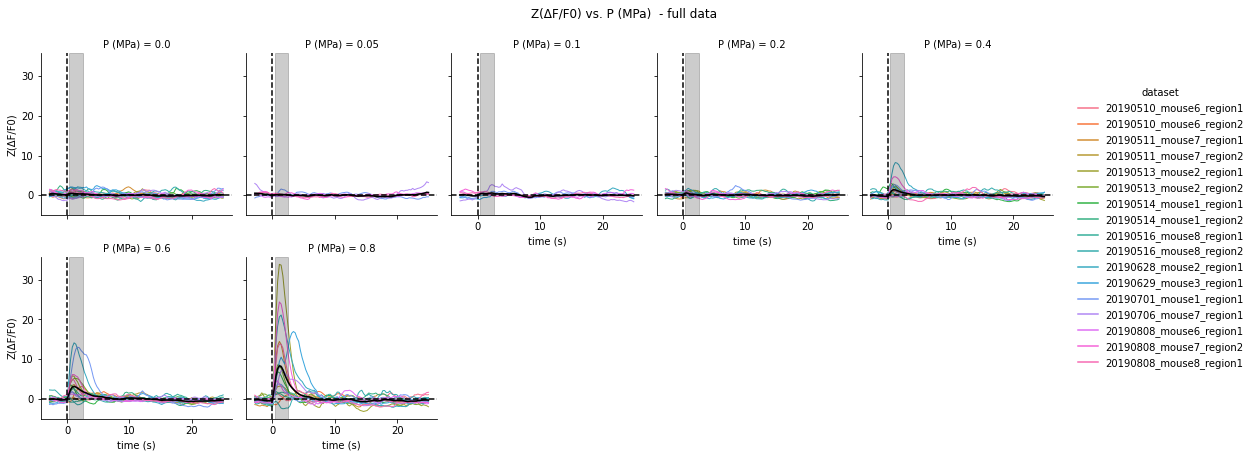

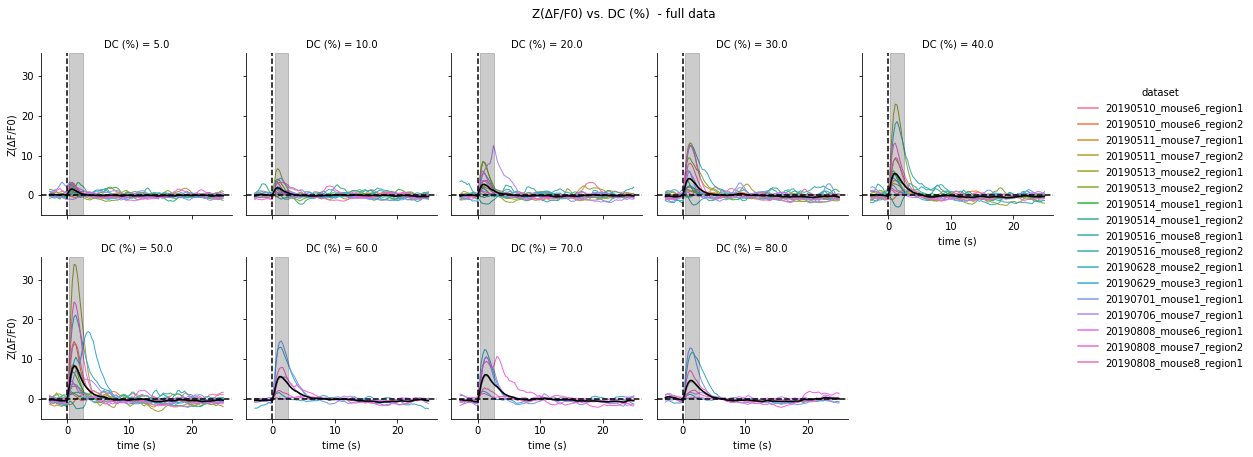

In [14]:
%%skip $skip_traces

# Variable of interest
ykey = Label.ZSCORE

# Flag to add per-dataset traces
dataset_traces = 'full'  # 'grey'

# Facetgrid kwargs
fgkwargs = dict(
    kind='line',
    col_wrap=5,
    height=3,
)

# For each input parameter
for xkey in [Label.P, Label.DC]:
    logger.info(f'plotting {ykey} vs. {xkey} response traces...')

    # Plot average traces for each dataset and sweep value, if requested
    if dataset_traces:
        # Plot average trace for each sweep value
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            x=Label.TIME,
            y=ykey,
            col=xkey,
            hue=Label.DATASET,
            palette=get_uniform_palette(g.data) if dataset_traces == 'grey' else None,
            legend='full' if dataset_traces == 'full' else False,
            errorbar=None, 
            lw=1,
            zorder=-1,
            **fgkwargs
        )
    
    # Plot global average trace for each sweep value
    pltkwargs = dict(
        x=Label.TIME, 
        y=ykey,
        color='k' if dataset_traces == 'full' else Palette.LINE[mouseline],
        errorbar='se',
    )
    if dataset_traces:
        g.map_dataframe(sns.lineplot, **pltkwargs)
    else:
        g = sns.relplot(
            data=get_xdep_data(plt_data, xkey),
            col=xkey,
            **pltkwargs,
            **fgkwargs
        )
    
    # Add vertical line at stimulus onset, and horizontal line at 0 
    g.refline(x=0, y=0, c='k')
    for ax in g.axes:
        ax.axvspan(tprops['left_ips'], tprops['right_ips'], color='k', alpha=.2)

    # Add title
    g.fig.suptitle(f'{ykey} vs. {xkey}  - full data', y=1.05)
    figs[f'{ykey} resp traces vs. {xkey} ext.'] = g.fig

### Plot response traces for each parametric sweep (1 axis per sweep)

 2024/06/17 16:47:33: sub-indexing data...
 2024/06/17 16:47:33: filtering data...
 2024/06/17 16:47:33: cross-checking filters...
 2024/06/17 16:47:33: grouping by P (MPa), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/06/17 16:47:40: sub-indexing data...
 2024/06/17 16:47:40: filtering data...
 2024/06/17 16:47:40: cross-checking filters...
 2024/06/17 16:47:41: grouping by DC (%), averaging and plotting mean ΔF/F0 vs. time (s) ...
 2024/06/17 16:47:49: sub-indexing data...
 2024/06/17 16:47:49: filtering data...
 2024/06/17 16:47:49: cross-checking filters...
 2024/06/17 16:47:50: grouping by P (MPa), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...
 2024/06/17 16:47:56: sub-indexing data...
 2024/06/17 16:47:56: filtering data...
 2024/06/17 16:47:57: cross-checking filters...
 2024/06/17 16:47:58: grouping by DC (%), averaging and plotting mean Z(ΔF/F0) vs. time (s) ...


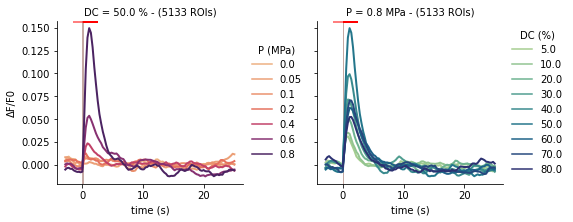

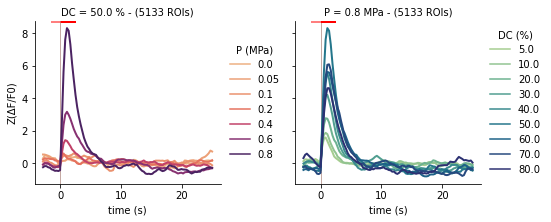

In [15]:
%%skip $skip_traces

# Determine input parameters
pkeys = [Label.P, Label.DC]

# Determine whether to group by responder type or not
groupby = None #Label.ROI_RESP_TYPE

# # Align DFF and z-score traces w.r.t their pre-stimulus average
# plt_data.loc[:, [Label.DFF, Label.ZSCORE]] = align_at(
#     plt_data[[Label.DFF, Label.ZSCORE]], get_window_slice(kind='pre'))

# For each output variable
for ykey in ykeys_plt:

    # # Pressure-dependent and duty cycle dependent response traces, per dataset
    # for pkey in pkeys:
    #     figs.update(
    #         plot_responses_across_datasets(
    #             plt_data, ykey=ykey, pkey=pkey, groupby=groupby))

    # Global (weighted) response curves for both input stimulation parameters
    avgaxes = []
    if groupby is None:
        figs[f'{ykey} resp traces'], axes = plt.subplots(
            1, len(pkeys), figsize=(4 * len(pkeys), 3), 
            sharey=True, gridspec_kw=dict(wspace=.4))
    else:
        axes = [None] * len(pkeys)
    for pkey, ax in zip(pkeys, axes):
        fig = plot_responses_across_datasets(
            plt_data, 
            ykey=ykey, 
            pkey=pkey, 
            ax=ax, 
            avg=True, 
            groupby=groupby,
            wpre=FrameIndex.NPRE, 
            wpost=npost,
            wcolor=Palette.LINE[mouseline],
        )
        if ax is not None:
            sns.move_legend(
                ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)
        else:
            if isinstance(fig, dict):
                figs.update(fig)
            else:
                figs[f'{ykey} resp traces vs. {pkey}'] = fig
                avgaxes += fig.axes
    if len(avgaxes) > 0:
        harmonize_axes_limits(avgaxes, axkey='y')

## Parameter dependency curves

### Compute and plot initial parameter dependency curves with appropriate response window size

 2024/06/17 16:48:08: applying mean function on ΔF/F0 in [5-11] index window across dataset, ROI, run
 2024/06/17 16:48:08: applying mean function on ΔF/F0 in [11-19] index window across dataset, ROI, run
 2024/06/17 16:48:08: computing evoked ΔF/F0 change...
 2024/06/17 16:48:08: applying mean function on Z(ΔF/F0) in [5-11] index window across dataset, ROI, run
 2024/06/17 16:48:08: applying mean function on Z(ΔF/F0) in [11-19] index window across dataset, ROI, run
 2024/06/17 16:48:08: computing evoked Z(ΔF/F0) change...
 2024/06/17 16:48:08: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/06/17 16:48:08: sub-indexing data...
 2024/06/17 16:48:08: filtering data...
 2024/06/17 16:48:08: cross-checking filters...
 2024/06/17 16:48:08: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/06/17 16:48:08: sub-indexing data...
 2024/06/17 16:48:08: filtering data...
 2024/06/17 16:48:08: cross-ch

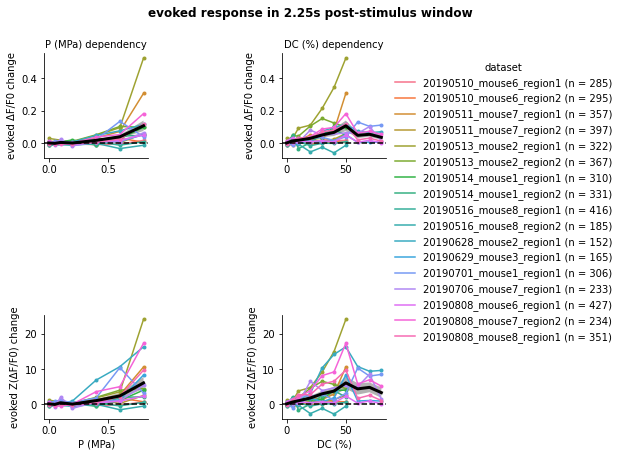

In [16]:
# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Whether to add detailed dataset traces
details = True

# Compute evoked responses for each variable of interest
for ykey in ykeys:
    ykey_diff = get_change_key(ykey)
    trialagg_stats[ykey_diff] = compute_evoked_change(
        trialagg_timeseries, 
        ykey, 
        npost=npost,  # Samples in determined post-stimulus window
    )

# Plot evoked response dependency on input parameters
figs['stimparams_init'] = plot_stimparams_dependency(
    trialagg_stats, 
    get_change_key(ykeys),
    xkeys=[Label.P, Label.DC],
    hue=Label.DATASET,
    palette='uniform' if not details else None,
    avgprop='whue', 
    avg_color='k' if details else 'line',
    errprop='inter',
    avgmarker='o',
    marker='.',
    errorbar=None,
)
figs['stimparams_init'].suptitle(
    f'evoked response in {npost / fps:.2f}s post-stimulus window', 
    fontsize=12, fontweight='bold', y=1.05)
if details:
    figs['stimparams_init'].subplots_adjust(wspace=.2)

### Temporary: Assess significance level of evoked responses

In [17]:
# # Define variable of interest
# ykey = Label.ZSCORE 
# ykey_diff = get_change_key(ykey)

# # Compute evoked change for rolling reference index
# logger.info(f'computing {ykey_diff} for rolling reference index...')
# resp_vs_iref = {}
# for iref in tqdm(np.arange(30, NFRAMES_PER_TRIAL - npost, step=3)):
#     resp_vs_iref[iref] = compute_evoked_change(
#         trialagg_timeseries, 
#         ykey, 
#         npost=npost,
#         iref=iref,
#         verbose=False,
#     )
# resp_vs_iref = pd.concat(
#     resp_vs_iref, names=['reference index'], axis=0).reset_index('reference index')

# # Compute summary statistics for evoked change in baseline periods
# logger.info(f'computing summary statistics for {ykey_diff} in baseline intervals...')
# resp_baseline_stats = resp_vs_iref[ykey_diff].agg({
#     'min': 'min',
#     '1%': lambda s: s.quantile(.01),
#     '5%': lambda s: s.quantile(.05),
#     'mean': 'mean',
#     'median': 'median',
#     '95%': lambda s: s.quantile(.95),
#     '99%': lambda s: s.quantile(.99),
#     'max': 'max',
#     'std': 'std',
# })

# # Plot distribution of evoked change for rolling reference index
# logger.info(f'plotting {ykey_diff} distribution in baseline intervals...')
# fig, ax = plt.subplots()
# sns.despine(ax=ax)
# ax.axhline(0, c='k', ls='--')
# sns.violinplot(
#     ax=ax,
#     data=resp_vs_iref.reset_index(),
#     y=ykey_diff,
#     cut=0,
# )
# ax.axvline(resp_baseline_stats['mean'], c='k')
# ax.axhspan(
#     resp_baseline_stats['mean'] - resp_baseline_stats['std'], 
#     resp_baseline_stats['mean'] + resp_baseline_stats['std'],
#     fc='k', alpha=0.3
# )
# ax.set_title(f'{ykey_diff} distribution for rolling reference index')

# # Plot evoked change dependency on reference index
# logger.info(f'plotting {ykey_diff} dependency on reference index...')
# fig, ax = plt.subplots()
# sns.despine(ax=ax)
# fig = plot_parameter_dependency(
#     resp_vs_iref, 
#     xkey='reference index',
#     ykey=ykey_diff,
#     hue=Label.DATASET,
#     palette='uniform' if not details else None,
#     avgprop='whue', 
#     avg_color='k',
#     errprop='inter',
#     avgmarker='o',
#     marker='.',
#     errorbar=None,
#     ax=ax,
# )

# # # Compute cross-dataset weighted mean and SEM across all reference index, and report it
# # logger.info(f'computing global cross-dataset weighted mean and SEM for {ykey_diff}...')
# # resp_vs_iref_agg = get_crossdataset_average(
# #     resp_vs_iref, 
# #     'reference index', 
# #     ykey=ykey_diff, 
# #     weighted=True, 
# #     errprop='inter',
# #     add_global_avg=False
# # ).set_index('reference index').mean()
# # mu_key, sem_key = get_propagg_keys(ykey)
# # ax.axhline(resp_vs_iref_agg[mu_key], c='k')
# # ax.axhspan(
# #     resp_vs_iref_agg[mu_key] - resp_vs_iref_agg[sem_key], 
# #     resp_vs_iref_agg[mu_key] + resp_vs_iref_agg[sem_key], 
# #     fc='k', ec=None, alpha=0.3
# # )

# # Plot evoked response dependency on input parameters
# fig = plot_stimparams_dependency(
#     trialagg_stats, 
#     ykey_diff,
#     xkeys=[Label.P, Label.DC],
#     avg_color=Palette.LINE[mouseline],
#     # hue=Label.DATASET,
#     # palette='uniform' if not details else None,
#     # avgprop='whue', 
#     # errprop='inter',
#     # avgmarker='o',
#     # marker='.',
#     # errorbar=None,
# )

# # Add shaded area to mark significance level of evoked change, 
# # based on evoked change distirbution in "baseline" 
# for ax in fig.axes:
#     # factor = pvalue_to_zscore(0.05)
#     # ax.axhline(resp_vs_iref_agg[mu_key], c='k')
#     # ax.axhspan(
#     #     resp_vs_iref_agg[mu_key] - factor * resp_vs_iref_agg[se_key], 
#     #     resp_vs_iref_agg[mu_key] + factor * resp_vs_iref_agg[se_key], 
#     #     fc='k', ec=None, alpha=0.3
#     # )
#     ax.axhline(resp_baseline_stats['mean'], c='k')
#     ax.axhspan(
#         resp_baseline_stats['5%'], 
#         resp_baseline_stats['95%'], 
#         fc='k', ec=None, alpha=0.3
#     )
#     ax.autoscale()
#     ax.autoscale_view()

### Inspect run presentation order per dataset and potential consequences on evoked activity

 2024/06/17 16:48:13: plotting I_SPTA (W/cm2) run sequence dependency across dataset...
 2024/06/17 16:48:13: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/06/17 16:48:13: sub-indexing data...
 2024/06/17 16:48:13: filtering data...
 2024/06/17 16:48:13: cross-checking filters...
 2024/06/17 16:48:13: grouping by dataset, averaging and plotting mean I_SPTA (W/cm2) vs. run ID ...
 2024/06/17 16:48:13: plotting evoked Z(ΔF/F0) change run sequence dependency across dataset...
 2024/06/17 16:48:13: run ID not part of (P (MPa), DC (%)) -> no filtering
 2024/06/17 16:48:13: sub-indexing data...
 2024/06/17 16:48:13: filtering data...
 2024/06/17 16:48:13: cross-checking filters...
 2024/06/17 16:48:13: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. run ID ...
 2024/06/17 16:48:14: adding sample counts per dataset on legend labels...
 2024/06/17 16:48:14: parameter sequences across datasets:


dataset,20190510_mouse6_region1,20190510_mouse6_region2,20190511_mouse7_region1,20190511_mouse7_region2,20190513_mouse2_region1,20190513_mouse2_region2,20190514_mouse1_region1,20190514_mouse1_region2,20190516_mouse8_region1,20190516_mouse8_region2,20190628_mouse2_region1,20190629_mouse3_region1,20190701_mouse1_region1,20190706_mouse7_region1,20190808_mouse6_region1,20190808_mouse7_region2,20190808_mouse8_region1
run ID,,,,,,,,,,,,,,,,,
0,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_30%DC,0.80MPa_50%DC,0.80MPa_50%DC,0.80MPa_50%DC
1,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_20%DC,0.80MPa_40%DC,0.80MPa_40%DC,0.80MPa_40%DC
2,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_10%DC,0.80MPa_30%DC,0.80MPa_30%DC,0.80MPa_30%DC
3,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_05%DC,0.80MPa_20%DC,0.80MPa_20%DC,0.80MPa_20%DC
4,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.00MPa_50%DC,0.80MPa_10%DC,0.80MPa_10%DC,0.80MPa_10%DC
5,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.60MPa_50%DC,0.80MPa_05%DC,0.80MPa_05%DC,0.80MPa_05%DC
6,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.00MPa_50%DC,0.40MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC
7,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.60MPa_50%DC,0.20MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC
8,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.40MPa_50%DC,0.10MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC,0.20MPa_50%DC


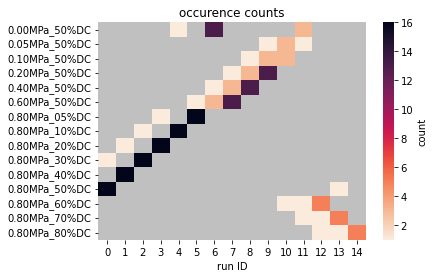

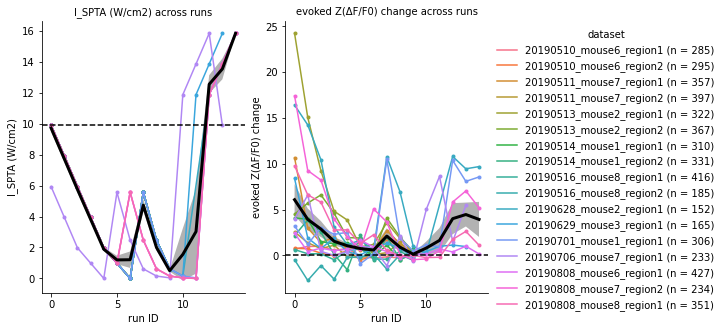

In [18]:
# Get parameter run sequence per dataset
param_seqs = trialagg_stats[[Label.RUNID, Label.P, Label.DC]].groupby([Label.DATASET, Label.RUNID]).first()
param_seqs = get_param_code(param_seqs).unstack().T

# Plot heatmap of occurence count across conditions and run IDs
params_counts = (param_seqs
    .apply(pd.Series.value_counts, axis=1)
    .fillna(0)
    .astype(int)
    .transpose()
)
figs['param count heatmap'], ax = plt.subplots()
ax.set_title('occurence counts')
cmap = sns.color_palette('rocket_r', as_cmap=True)
cmap.set_under('silver')
sns.heatmap(
    data=params_counts, 
    ax=ax, 
    cmap=cmap, 
    cbar_kws={'label': 'count'},
    vmin=1,
)

# Plot Ispta and evoked response across run sequences, per dataset
ykeys_seq = [Label.ISPTA, ykey_diff]
Ispta_ref = pressure_to_intensity(P_REF / PA_TO_MPA) / M2_TO_CM2 * DC_REF / 1e2
figs['rundeps_global'], axes = plt.subplots(1, len(ykeys_seq), figsize=(4 * len(ykeys_seq), 5))
for i, (ykey, ax) in enumerate(zip(ykeys_seq, np.atleast_1d(axes))):
    # Plot run sequence dependencies across datasets
    logger.info(f'plotting {ykey} run sequence dependency across dataset...')
    plot_parameter_dependency(
        trialagg_stats, 
        xkey=Label.RUNID, 
        ykey=ykey,
        yref=Ispta_ref if ykey == Label.ISPTA else 0., 
        hue=Label.DATASET, 
        errorbar=None, 
        avgprop='whue', 
        errprop='inter',
        ax=ax, 
        legend=i == len(ykeys_seq) - 1, 
        title=f'{ykey} across runs',
        marker='.',
    )

logger.info('parameter sequences across datasets:')
param_seqs

### Classify responses and responders

In [19]:
# Classify responses based on response z-score values
zthr = pvalue_to_zscore(PTHR_DETECTION, directional=directional)
trialagg_stats[Label.RESP_TYPE] = zscore_to_resp_type(
    trialagg_stats[ykey_diff], zthr, directional=directional)

# TODO: classify responders

 2024/06/17 16:48:16: classifying responses using directional z-score thresholding ...


### ROI breakdown per dataset

 2024/06/17 16:48:18: computing fraction of response occurence per ROI over 9 "strong ISPTA" conditions...
 2024/06/17 16:48:19: identified 50.6% of responders with 0.5 as threshold proportion of responding conditions
 2024/06/17 16:48:19: plotting cell maps...


100%|██████████| 17/17 [00:47<00:00,  2.77s/it]


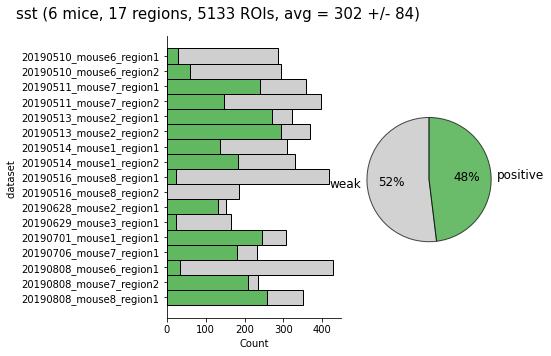

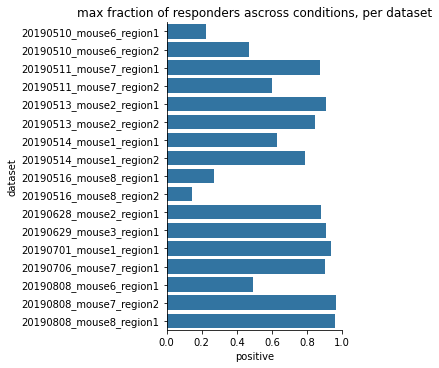

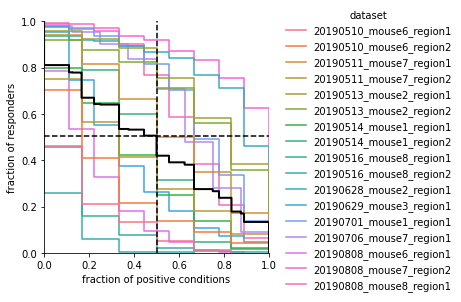

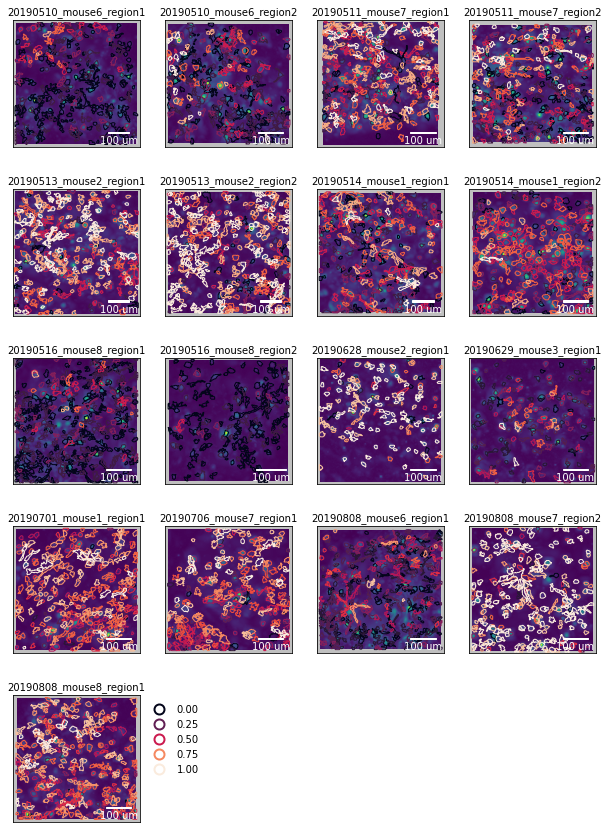

In [20]:
# Plot cell count distribution and breakdown
figs['rtype dist per mousereg'] = plot_cellcounts(
    trialagg_stats, hue=Label.ROI_RESP_TYPE, title=mouseline)

# Plot distribution of max number of responders across conditions 
resp_counts = (
    trialagg_stats[Label.RESP_TYPE]
    .groupby([Label.DATASET, Label.RUN])
    .value_counts().unstack()
)
resp_counts['total'] = resp_counts.sum(axis=1)
resp_props = resp_counts.div(resp_counts['total'], axis=0)
max_pos_props= resp_props['positive'].groupby(Label.DATASET).max()
max_pos_props = max_pos_props.to_frame().reset_index()
fg = sns.catplot(
    data=max_pos_props,
    kind='bar', 
    x='positive', 
    y=Label.DATASET,
    color='C0'
)
fg.figure.axes[0].set_xlim(0, 1)
fg.figure.axes[0].set_title('max fraction of responders ascross conditions, per dataset')
figs['max % resp'] = fg.figure

# Plot cell classification details 
figs['classification details'] = plot_classification_details(
    trialagg_stats, pthr=PROP_CONDS_THR, hue=Label.DATASET)

# Plot cell maps
figs['cellmaps with rtype'] = plot_fields_of_view(
    map_ops, 
    ROI_masks=ROI_masks,
    Fstats=trialagg_stats, 
    refkey='Vcorr', 
    mode='contour', 
    hue='positive'
)

### Plot evoked change distribution for control condition (P = 0)

 2024/06/17 16:49:11: response type proportions at P = 0:
response type
weak        90.726671
positive     9.273329
Name: count, dtype: float64


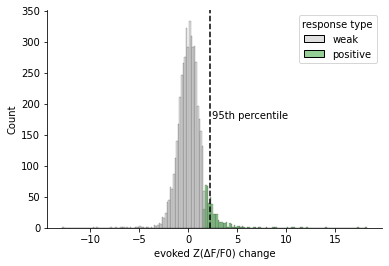

In [21]:
trialagg_stats0 = trialagg_stats[trialagg_stats[Label.P] == 0]
ykeydiff = get_change_key(Label.ZSCORE)

# Plot distribution of evoked response for baseline condition with response class color code
figs[f'{ykey_diff} dist baseline'], ax = plt.subplots()
sns.despine(ax=ax)
sns.histplot(
    ax=ax,
    data=trialagg_stats0,
    x=ykeydiff,
    hue=Label.RESP_TYPE,
    hue_order=get_default_rtypes(),
    palette=Palette.RTYPE
)
# Add 95th percentile location
q95 = trialagg_stats0[ykeydiff].quantile(.95)
ax.axvline(q95, c='k', ls='--')
ax.text(1.1 * q95, 0.5 * ax.get_ylim()[1], '95th percentile')

# Log responder fraction information
props0 = trialagg_stats0[Label.RESP_TYPE].value_counts() / len(trialagg_stats0) * 100
logger.info(f'response type proportions at P = 0:\n{props0}')

### Extract dictionary of fits per input parameters for current mouse line 

In [22]:
fit_dict = get_fit_table()[mouseline]
logger.info(f'fit_dict:\n{fit_dict}')

 2024/06/17 16:49:12: fit_dict:
parameter
P (MPa)                               poly2
DC (%)              corrected_sigmoid_decay
P_SPTA (MPa)        corrected_sigmoid_decay
P_SPTRMS (MPa)      corrected_sigmoid_decay
I_SPTA (W/cm2)      corrected_sigmoid_decay
I_SPTRMS (W/cm2)    corrected_sigmoid_decay
Name: sst, dtype: object


### Plot parameter dependency curves, with fits

 2024/06/17 16:49:13: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/06/17 16:49:13: sub-indexing data...
 2024/06/17 16:49:13: filtering data...
 2024/06/17 16:49:13: cross-checking filters...
 2024/06/17 16:49:13: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. P (MPa) ...
 2024/06/17 16:49:14: performing "evoked ΔF/F0 change ~ P (MPa)" type 1 ANOVA
 2024/06/17 16:49:14: fitting order 2 polynomial to data
 2024/06/17 16:49:14: fitting results: popt = [0.25, -0.077, 0.0062], R2 = 0.98
 2024/06/17 16:49:14: sub-indexing data...
 2024/06/17 16:49:14: filtering data...
 2024/06/17 16:49:14: cross-checking filters...
 2024/06/17 16:49:14: grouping by dataset, averaging and plotting mean evoked ΔF/F0 change vs. DC (%) ...
 2024/06/17 16:49:14: performing "evoked ΔF/F0 change ~ DC (%)" type 1 ANOVA
 2024/06/17 16:49:14: computing fit with sigmoid_decay function: p0 = [40, 0.022, 0.0022, 0.11]
 2024/06/17 16:49

/gpfs/data/shohamlab/theo/code/usnm2p/utils.py:963: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-k * (x - x0))) * np.exp(-r * (x - x0)) + y0
/gpfs/data/shohamlab/theo/code/usnm2p/utils.py:1202: RuntimeWarning: invalid value encountered in subtract
  return y - corrfunc(y)


 2024/06/17 16:49:14: performing "evoked ΔF/F0 change ~ I_SPTA (W/cm2)" type 1 ANOVA
 2024/06/17 16:49:15: computing fit with sigmoid_decay function: p0 = [7.9, 0.11, 0.011, 0.11]
 2024/06/17 16:49:15: fitting results: popt = [8.8, 0.49, 0.2, 0.19], R2 = 0.88
 2024/06/17 16:49:15: plotting ['evoked ΔF/F0 change', 'evoked Z(ΔF/F0) change'] stimulation parameters dependencies...
 2024/06/17 16:49:15: sub-indexing data...
 2024/06/17 16:49:15: filtering data...
 2024/06/17 16:49:15: cross-checking filters...
 2024/06/17 16:49:15: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. P (MPa) ...
 2024/06/17 16:49:15: performing "evoked Z(ΔF/F0) change ~ P (MPa)" type 1 ANOVA


/gpfs/data/shohamlab/theo/code/usnm2p/utils.py:963: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-k * (x - x0))) * np.exp(-r * (x - x0)) + y0
/gpfs/data/shohamlab/theo/code/usnm2p/utils.py:1202: RuntimeWarning: invalid value encountered in subtract
  return y - corrfunc(y)


 2024/06/17 16:49:15: fitting order 2 polynomial to data
 2024/06/17 16:49:15: fitting results: popt = [14, -4.2, 0.36], R2 = 0.98
 2024/06/17 16:49:15: sub-indexing data...
 2024/06/17 16:49:15: filtering data...
 2024/06/17 16:49:15: cross-checking filters...
 2024/06/17 16:49:15: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. DC (%) ...
 2024/06/17 16:49:15: performing "evoked Z(ΔF/F0) change ~ DC (%)" type 1 ANOVA
 2024/06/17 16:49:15: computing fit with sigmoid_decay function: p0 = [40, 0.025, 0.0025, 6.1]
 2024/06/17 16:49:15: fitting results: popt = [55, 0.068, 0.033, 15], R2 = 0.94
 2024/06/17 16:49:15: I_SPTA (W/cm2) not part of (P (MPa), DC (%)) -> no filtering
 2024/06/17 16:49:15: sub-indexing data...
 2024/06/17 16:49:15: filtering data...
 2024/06/17 16:49:15: cross-checking filters...
 2024/06/17 16:49:15: grouping by dataset, averaging and plotting mean evoked Z(ΔF/F0) change vs. I_SPTA (W/cm2) ...
 2024/06/17 16:49:16: performing "evoked Z(

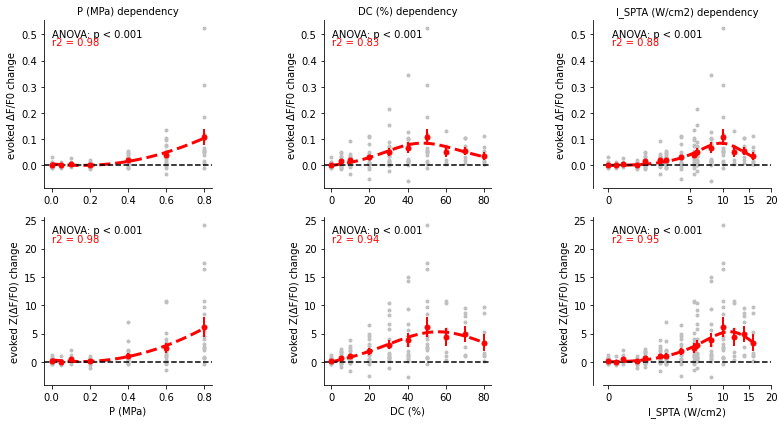

In [23]:
# Variables of interest
ykeys_resp = [get_change_key(k) for k in ykeys_plt] #+ [Label.RESP_FRAC]

# Plot evoked response dependency on input parameters, with fits
figs['stimparamdeps post curation'] = plot_stimparams_dependency(
    trialagg_stats,
    ykeys_resp,
    xkeys=xkeys_plt,  
    hue=Label.DATASET,
    palette='uniform',
    avgprop='whue', 
    avg_color='line',
    avgmarker='o',
    marker='.', 
    lw=0,
    errorbar=None,
    err_style='bars',
    fit=fit_dict,
)

### Plot P - DC alignment for various dose projections

 2024/06/17 16:49:18: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) "evoked ΔF/F0 change" series across run...
 2024/06/17 16:49:18: computing fit with sigmoid_decay function: p0 = [0.32, 2.8, 0.28, 0.11]
 2024/06/17 16:49:18: fitting results: popt = [0.34, 12, 4.6, 0.2], R2 = 0.83


/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/06/17 16:49:18: computing fit with sigmoid_decay function: p0 = [7.9, 0.11, 0.011, 0.11]
 2024/06/17 16:49:19: fitting results: popt = [8.5, 0.48, 0.19, 0.2], R2 = 0.83
 2024/06/17 16:49:19: computing fit with sigmoid_decay function: p0 = [11, 0.12, 0.012, 0.11]
 2024/06/17 16:49:19: fitting results: popt = [12, 0.85, 0.53, 0.17], R2 = 0.84
 2024/06/17 16:49:19: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) "evoked Z(ΔF/F0) change" series across run...


/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


 2024/06/17 16:49:19: computing fit with sigmoid_decay function: p0 = [0.32, 3.1, 0.31, 6.1]
 2024/06/17 16:49:19: fitting results: popt = [0.44, 8.5, 4.1, 15], R2 = 0.94
 2024/06/17 16:49:19: computing fit with sigmoid_decay function: p0 = [7.9, 0.13, 0.013, 6.1]
 2024/06/17 16:49:19: fitting results: popt = [11, 0.34, 0.17, 15], R2 = 0.94
 2024/06/17 16:49:19: computing fit with sigmoid_decay function: p0 = [11, 0.15, 0.015, 6.1]
 2024/06/17 16:49:19: fitting results: popt = [14, 0.74, 0.47, 11], R2 = 0.94


/gpfs/home/lemait01/.conda/envs/usnm2p/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


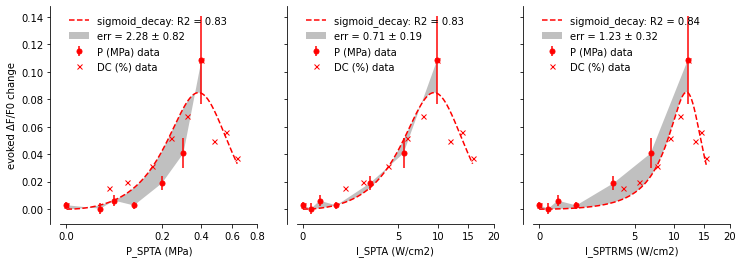

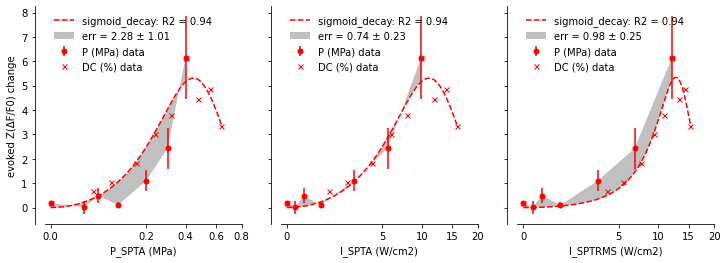

In [24]:
# Dose metrics
xkeys = [
    Label.PSPTA,
    Label.ISPTA,
    Label.ISPTRMS,
]

# Variables of interest
ykeys = [
    Label.DFF,
    Label.ZSCORE
]

# Dependent response variables
ykey_diffs = get_change_key(ykeys)

# Evaluate and plot alignment between DC sweep sigmoid predictors 
# and P sweep data
for ykey_diff in ykey_diffs:
    figs[f'resp alignment {ykey_diff}'] = plot_response_alignment(
        trialagg_stats,
        xkeys, 
        ykey_diff,
        fit_dict, 
        xscale='sqrt', 
        height=4,
    )   

### Comparison across layers (if applicable)

In [26]:
# dataset_ids = trialagg_stats.index.unique(Label.DATASET)
# layers = pd.Series(
#     [{True: 'layer5', False: 'layer2/3'}[s.endswith('layer5')] for s in dataset_ids],
#     index=dataset_ids,
#     name=Label.LAYER
# )
# logger.info(f'datasets count by layer:\n{layers.value_counts()}')
# if len(layers.value_counts()) > 1:
#     layer_palette = layers.map(
#         dict(zip(layers.unique(), mcolors.TABLEAU_COLORS.keys()))).to_dict()
#     trialagg_stats[Label.LAYER] = free_expand(layers, trialagg_stats)
#     fig = plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.DATASET,
#         hue_alpha=.5,
#         palette=layer_palette,
#         errorbar=None
#     )

#     plot_stimparams_dependency(
#         trialagg_stats.copy(),
#         xkeys=xkeys_plt,
#         ykey=ykey_diff, 
#         hue=Label.LAYER,
#         palette=layer_palette,
#         axes=np.array(fig.axes),
#         lw=10,
#         errorbar=None
#     )

## Response variability analysis (on valid trials)

### Get stats for valid trials

In [27]:
valid_stats = ext_stats[~ext_stats[Label.DISCARDED]]
valid_stats

line  trial_length  PRF (Hz)  \
dataset                 ROI run trial                                
20190510_mouse6_region1 2   0   1      sst           100     100.0   
                                2      sst           100     100.0   
                                3      sst           100     100.0   
                                4      sst           100     100.0   
                                5      sst           100     100.0   
...                                    ...           ...       ...   
20190808_mouse8_region1 592 14  11     sst           100     100.0   
                                12     sst           100     100.0   
                                13     sst           100     100.0   
                                14     sst           100     100.0   
                                15     sst           100     100.0   

                                       duration (s)   fps  P (MPa)  DC (%)  \
dataset                 ROI run trial                                        
20190510_mouse6_region1 2   0   1               0.2  3.56      0.0    50.0   
                                2               0.2  3.56      0.0    50.0   
                                3               0.2  3.56      0.0    50.0   
                                4               0.2  3.56      0.0    50.0   
                                5               0.2  3.56      0.0    50.0   
...                                             ...   ...      ...     ...   
20190808_mouse8_region1 592 14  11              0.2  3.56      0.8    80.0   
                                12              0.2  3.56      0.8    80.0   
                                13              0.2  3.56      0.8    80.0   
                                14              0.2  3.56      0.8    80.0   
                                15              0.2  3.56      0.8    80.0   

                                       run ID  I_SPPA (W/cm2)  I_SPTA (W/cm2)  \
dataset                 ROI run trial                                           
20190510_mouse6_region1 2   0   1           6        0.000000         0.00000   
                                2           6        0.000000         0.00000   
                                3           6        0.000000         0.00000   
                                4           6        0.000000         0.00000   
                                5           6        0.000000         0.00000   
...                                       ...             ...             ...   
20190808_mouse8_region1 592 14  11         14       19.784475        15.82758   
                                12         14       19.784475        15.82758   
                                13         14       19.784475        15.82758   
                                14         14       19.784475        15.82758   
                                15         14       19.784475        15.82758   

                                       ...  baseline pre-stim avg Z(ΔF/F0)  \
dataset                 ROI run trial  ...                                   
20190510_mouse6_region1 2   0   1      ...                        0.436113   
                                2      ...                        0.330091   
                                3      ...                       -0.751347   
                                4      ...                       -0.487931   
                                5      ...                        1.847361   
...                                    ...                             ...   
20190808_mouse8_region1 592 14  11     ...                       -1.007442   
                                12     ...                       -0.626448   
                                13     ...                        0.340294   
                                14     ...                       -0.472748   
                                15     ...                        0.843742   

                                       base

### 2-way (ROI:TRIAL) ANOVA analysis

 2024/04/05 11:06:03: performing "evoked Z(ΔF/F0) change ~ C(ROI) + C(trial)" type 1 ANOVA across ['dataset', 'run']


100%|██████████| 202/202 [00:59<00:00,  3.42it/s]

 2024/04/05 11:07:03: adding ISPTA and RUNID columns to ANOVA stats...
 2024/04/05 11:07:04: plotting ['ΔF/F0', 'Z(ΔF/F0)'] ANOVA stats across ['ROI', 'trial'] factors...



/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

C(ROI) vs. C(trial): Mann-Whitney-Wilcoxon test two-sided, P_val:1.368e-66 U_stat=1.720e+02


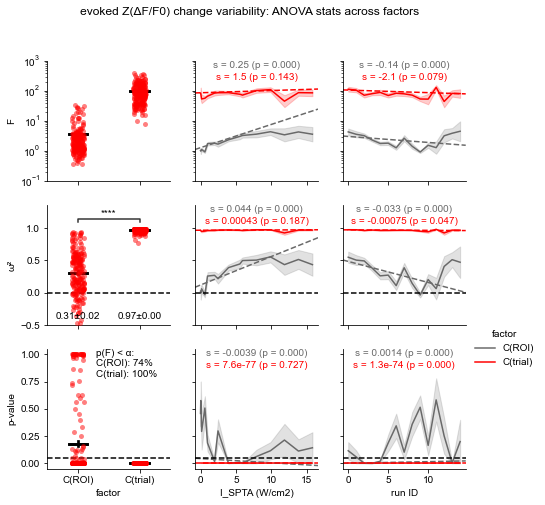

In [28]:
# Determing grouping variables
gby = [Label.DATASET, Label.RUN]

# Determine variable of interest
ykey_diff = get_change_key(Label.ZSCORE)

# Perform 2-way ANOVA on response strength across ROI and trials, across groups
factors = [Label.ROI, Label.TRIAL]
ANOVA_stats = anova(valid_stats, ykey_diff, factors, full_output=True, gby=gby, typ=1, interaction=False)
factor_pairs = list(itertools.combinations(ANOVA_stats.index.unique('factor').drop('Residual').values, 2))

# Add ISPTA and RUNID columns to ANOVA stats
logger.info('adding ISPTA and RUNID columns to ANOVA stats...')
run_stats = valid_stats[[Label.ISPTA, Label.RUNID]].groupby(gby).min()
ANOVA_stats = expand_to_match(run_stats, ANOVA_stats.index).join(ANOVA_stats)

# Compute proportion of significant factor dependencies for each factor
pvals = ANOVA_stats['p-value'].drop(index='Residual', level='factor').unstack('factor')
prop_sig_factors = (pvals < PTHR_DETECTION).sum() / len(pvals)
prop_sig_factors_str = '\n'.join(['p(F) < α:'] + [f'{k}: {v * 1e2:.0f}%' for k, v in prop_sig_factors.items()])

# Plot ANOVA stats (effect size and p-value) across factors, across ISPTA and run order
logger.info(f'plotting {ykeys} ANOVA stats across {factors} factors...')
xkeys = ['factor', Label.ISPTA, Label.RUNID]
palette = {
    parse_factor(Label.ROI, True): 'dimgray',
    parse_factor(Label.TRIAL, True): Palette.LINE[mouseline],
}
ykeys = ['F', 'ω²', 'p-value']
ythrs = {
    'F': 0,
    'ω²': 0,
    'p-value': PTHR_DETECTION,
}
height = 2.5
figs['resp anova stats'], axes = plt.subplots(
    len(ykeys), len(xkeys), 
    figsize=(height * len(xkeys), height * len(ykeys)), 
    sharey='row', sharex='col')
figs['resp anova stats'].suptitle(f'{ykey_diff} variability: ANOVA stats across factors')
pltkwargs = {'data': ANOVA_stats.drop(index='Residual', level='factor').reset_index()}
for axrow, yk in zip(axes, ykeys):
    pltkwargs['y'] = yk
    if yk == 'F':
        axrow[0].set_yscale('log')
        axrow[0].set_ylim(1e-1, 1e3)
    elif yk == 'ω²':
        axrow[0].set_ylim(-0.5, 1.3)
    if yk == 'p-value':
        axrow[0].set_ylim(-0.05, 1.05)
    for ax, xk in zip(axrow, xkeys):
        sns.despine(ax=ax)
        pltkwargs.update(dict(
            x=xk,
        ))
        # If x = factor, use stripplot to compare across factors
        if xk == 'factor':
            sns.stripplot(
                ax=ax,
                alpha=0.5,
                color=Palette.LINE[mouseline],
                **pltkwargs
            )
            add_mean_and_sem_bars(ax=ax, **pltkwargs, color='k')
            # For omega-squared, add statistical comparison between factors and mean +/- sem summary
            if yk == 'ω²':
                annotator = Annotator( 
                    ax,
                    factor_pairs, 
                    **pltkwargs)
                annotator.configure(test='Mann-Whitney')
                annotator.apply_and_annotate()
                wstats = ANOVA_stats[yk].groupby(xk).agg(['mean', 'sem']).drop('Residual')
                for i, (factor, (wmu, wsem)) in enumerate(wstats.iterrows()):
                    ax.text(i, -0.3, f'{wmu:.2f}±{wsem:.2f}', ha='center', va='top')
            # For p-values, add proportion of significant factors
            elif yk == 'p-value':
                ax.text(0.4, 1., prop_sig_factors_str, transform=ax.transAxes, va='top')
        # Otherwise, use lineplot to compare factors across ISPTA / run order
        else:
            legend = yk == ykeys[-1] and xk == xkeys[-1]
            sns.lineplot(
                ax=ax,
                errorbar='se',
                hue='factor',
                palette=palette,
                legend=legend,
                **pltkwargs
            )
            ytxt = 1.
            for factor, subdata in pltkwargs['data'].groupby('factor'):
                subkwargs = pltkwargs.copy()
                subkwargs['data'] = subdata
                subkwargs['color'] = palette[factor]
                add_regression_line(ax=ax, **subkwargs, robust=True, ytxt=ytxt, add_text=True, ls='--')
                ytxt -= .1
            if legend:
                sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 1), frameon=False)                
        ax.axhline(ythrs[yk], c='k', ls='--')

### Inter-ROI response correlation

 2024/04/05 11:07:05: shuffling evoked Z(ΔF/F0) change data within ['dataset', 'ROI', 'run'] groups


100%|██████████| 60120/60120 [00:18<00:00, 3179.70it/s]


 2024/04/05 11:07:28: computing pairwise response correlations between ROIs...
 2024/04/05 11:07:33: mean response correlations between ROIs:
kind
original    0.319960
shuffled    0.000089
Name: R, dtype: float64
 2024/04/05 11:07:36: expanding (17 datasets x 15 runs) "I_SPTA (W/cm2)" series to match (17 datasets x 15 runs x 1144 ROI1s x 1141 ROI2s) reference dataframe
 2024/04/05 11:07:53: plotting response correlations between ROIs...
 2024/04/05 11:08:19: adding statistical comparisons...
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

original vs. shuffled: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=7.049e+13
 2024/04/05 11:08:47: plotting response correlations vs ISPTA...


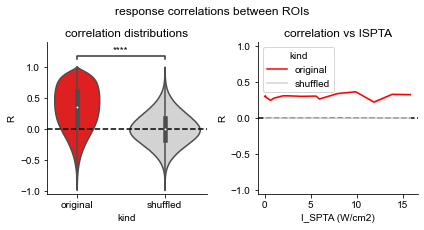

In [29]:
# Construct dictionary of original and transformed response statistics
resp_stats = {'original': valid_stats[ykey_diff]}
resp_stats['shuffled'] = shuffle(resp_stats['original'], gby=excluded(valid_stats, Label.TRIAL))
# resp_stats['rolled'] = cyclic_shift(resp_stats['original'], gby=excluded(valid_stats, Label.TRIAL))
resp_stats = pd.concat(resp_stats, names=['kind'])

# Compute cross-ROI correlations
logger.info('computing pairwise response correlations between ROIs...')
resp_corrs = compute_crossROIs_correlations(resp_stats, by=['kind', Label.DATASET, Label.RUN])
logger.info('mean response correlations between ROIs:')
print(resp_corrs.groupby('kind').mean())

# Add ispta information to response correlations
isptas = get_params_by_run(valid_stats, extra_dims=Label.DATASET)[Label.ISPTA]
exp_isptas = free_expand(isptas, resp_corrs.loc['original'])
exp_isptas = pd.concat({k: exp_isptas for k in resp_corrs.index.unique('kind')}, names=['kind'])
resp_corrs = pd.concat([resp_corrs, exp_isptas], axis=1)

# Aggregate response across ROIs by collapsing across ROI2 axis
agg_resp_corrs = resp_corrs.groupby(excluded(resp_corrs, 'ROI2')).mean()
agg_resp_corrs[Label.ISPTA] = agg_resp_corrs[Label.ISPTA].round(2)

# Create figure
figs['inter ROI correlations'], axes = plt.subplots(1, 2, figsize=(6, 3))
for ax in axes:
    sns.despine(ax=ax)

# Plot distribution of response correlations for original and transformed data
logger.info('plotting response correlations between ROIs...')
ax = axes[0]
ax.set_title('correlation distributions')
ax.set_ylim(-1.05, 1.05)
ax.axhline(0, c='k', ls='--')
pltkwargs = dict(
    data=resp_corrs.reset_index(),
    y='R',
    x='kind',
)
cdict = {
    'original': Palette.LINE[mouseline], 
    'shuffled': 'lightgrey', 
    'rolled': 'dimgray'
}
sns.violinplot(
    ax=ax,
    **pltkwargs,
    palette=cdict,
    cut=0,
)

# Add statistical comparison between original and transformed data
logger.info('adding statistical comparisons...')
pairs = list(itertools.combinations(pltkwargs['data']['kind'].unique(), 2))
annotator = Annotator(ax, pairs, **pltkwargs)
annotator.configure(test='Mann-Whitney')
annotator.apply_and_annotate()

# Plot ISPTA dependency of correlation between ROIs
logger.info('plotting response correlations vs ISPTA...')
ax = axes[1]
ax.set_title('correlation vs ISPTA')
ax.set_ylim(-1.05, 1.05)
ax.axhline(0, c='k', ls='--')
sns.lineplot(
    ax=ax,
    data=agg_resp_corrs.reset_index(),
    x=Label.ISPTA,
    y='R',
    hue='kind',
    palette=cdict,
    errorbar='se',
)

# Adjust layout
figs['inter ROI correlations'].tight_layout()
figs['inter ROI correlations'].suptitle('response correlations between ROIs', y=1.05);

### Principal component analysis of response across ROIs and trials

 2024/04/05 11:08:48: fitting PC tensor to (ROI x trial) evoked Z(ΔF/F0) change input across ['kind', 'dataset', 'run']


100%|██████████| 404/404 [00:01<00:00, 251.03it/s]

 2024/04/05 11:08:51: extracting explained variance from PCA results


 2024/04/05 11:08:51: expanding (17 datasets x 15 runs) "I_SPTA (W/cm2)" series to match (17 datasets x 15 runs x 15 PCs) reference dataframe
 2024/04/05 11:08:51: plotting explained variance per PC
 2024/04/05 11:08:51: plotting explained variance of first PC vs ISPTA


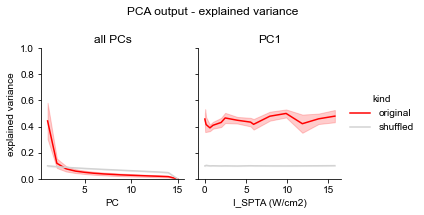

In [30]:
# Use PCA to decompose response statistics, and extract explained variance per PC
gby = ['kind', Label.DATASET, Label.RUN]
pca_out = fit_PCA(resp_stats, gby=gby)
expvar = extract_explained_variance(pca_out)

# Add ISPTA information to explained variance
exp_isptas = free_expand(isptas, expvar.loc['original'])
exp_isptas = pd.concat({k: exp_isptas for k in expvar.index.unique('kind')}, names=['kind'])
expvar = pd.concat([expvar, exp_isptas], axis=1)

# Create figure
figs['pca expl. variance'], axes = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
figs['pca expl. variance'].suptitle('PCA output - explained variance')
axes[0].set_ylim(0, 1)
for ax in axes:
    sns.despine(ax=ax)

# Plot explained variance per PC
logger.info('plotting explained variance per PC')
ax = axes[0]
ax.set_title('all PCs')
fg = sns.lineplot(
    ax=ax,
    data=expvar.reset_index(),
    x='PC',
    y='explained variance',
    hue='kind',
    palette=cdict,
    errorbar='sd',
    legend=False,
)

# Plot explained variance of first PC vs. ISPTA
PC1_expvar = expvar.groupby(excluded(expvar, 'PC')).first()
logger.info('plotting explained variance of first PC vs ISPTA')
ax = axes[1]
ax.set_title('PC1')
sns.lineplot(
    ax=ax,
    data=PC1_expvar.reset_index(),
    x=Label.ISPTA,
    y='explained variance',
    hue='kind',
    palette=cdict,
    errorbar='se',
)
sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Adjust layout
figs['pca expl. variance'].tight_layout()

### Z-score population average response vectors across datasets and conditions

In [36]:
# Compute population average response strengths over valid trials
popagg_valid_stats = get_popavg_data(valid_stats)

# Determine variable of interest
ykey_diff = get_change_key(Label.ZSCORE)

# Determine grouping variables
gby = excluded(popagg_valid_stats, Label.TRIAL)

# Z-score response vs trial sequences
logger.info(f'z-scoring population average {ykey_diff} response vs. trial sequences...')
groups = popagg_valid_stats[ykey_diff].groupby(gby)
with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
    zscored_popagg_resp = groups.apply(pbar_update(
        lambda x: ((x - x.mean()) / x.std()).droplevel(gby), pbar))
# Add ISPTA and run ID info
zscored_popagg_resp = pd.concat([
    zscored_popagg_resp.to_frame(),
    popagg_valid_stats[[Label.ISPTA, Label.RUNID]]
], axis=1)

zscored_popagg_resp

 2024/04/05 13:05:50: computing population average data across (dataset, run, trial)...
 2024/04/05 13:05:52: z-scoring population average evoked Z(ΔF/F0) change response vs. trial sequences...


202it [00:00, 2287.84it/s]             


evoked Z(ΔF/F0) change  I_SPTA (W/cm2)  \
dataset                 run trial                                           
20190510_mouse6_region1 0   1                   -1.051155         0.00000   
                            2                    1.694968         0.00000   
                            3                   -0.989869         0.00000   
                            4                   -0.365567         0.00000   
                            5                   -0.690971         0.00000   
...                                                   ...             ...   
20190808_mouse8_region1 14  11                   1.689141        15.82758   
                            12                  -1.469873        15.82758   
                            13                  -0.715025        15.82758   
                            14                  -0.917967        15.82758   
                            15                  -0.522212        15.82758   

                                   run ID  
dataset                 run trial          
20190510_mouse6_region1 0   1           6  
                            2           6  
                            3           6  
                            4           6  
                            5           6  
...                                   ...  
20190808_mouse8_region1 14  11         14  
                            12         14  
                            13         14  
                            14         14  
                            15         14  

[3030 rows x 3 columns]

### Compute tests on z-scored response vectors

In [38]:
# Determine grouping variables
gby = excluded(zscored_popagg_resp, Label.TRIAL)
groups = zscored_popagg_resp[ykey_diff].groupby(gby)

# Regress z-scored response strength vs trial, across groups
logger.info(f'regressing z-scored {ykey_diff} vs. {Label.TRIAL} across {gby}...')
regres = groups.apply(apply_linregress)
regres = regres.unstack(level=-1)
regres['sig'] = regres['pval'] < PTHR_DETECTION

# Compute tests for unimodality and normality of distirbutions
logger.info(f'testing for unimodality and normality of z-scored {ykey_diff} distributions...')
normres = (groups
    .apply(shapiro)
    .apply(pd.Series)
    .rename(columns={0: 'stat', 1: 'pval'})
)
dipres = (groups
    .apply(diptest.diptest)
    .apply(pd.Series)
    .rename(columns={0: 'stat', 1: 'pval'})
)

# Assemble into response statistics dataframe, and add ISPTA and RUNID columns to it 
zscored_popagg_resp_stats = pd.concat([
    zscored_popagg_resp[[Label.ISPTA, Label.RUNID]].groupby(gby).min(),
    regres.add_prefix('reg '),
    normres.add_prefix('norm '),
    dipres.add_prefix('dip ')
], axis=1)

zscored_popagg_resp_stats

 2024/04/05 13:06:40: regressing z-scored evoked Z(ΔF/F0) change vs. trial across ['dataset', 'run']...
 2024/04/05 13:06:40: testing for unimodality and normality of z-scored evoked Z(ΔF/F0) change distributions...


I_SPTA (W/cm2)  run ID  reg intercept  reg slope  \
dataset                 run                                                     
20190510_mouse6_region1 0          0.000000       6      -0.555658   0.069457   
                        3          0.618265       9       0.377594  -0.047199   
                        4          2.473059       8       0.197246  -0.024656   
                        5          5.564384       7      -0.393999   0.049250   
                        6          0.989224       5       0.233483  -0.029185   
...                                     ...     ...            ...        ...   
20190808_mouse8_region1 10         7.913790       1       0.796654  -0.099582   
                        11         9.892238       0       0.876375  -0.109547   
                        12        11.870685      12       0.493235  -0.061654   
                        13        13.849133      13       0.468065  -0.058508   
                        14        15.827580      14       0.662603  -0.082825   

                             reg pval    reg r2  reg sig  norm stat  \
dataset                 run                                           
20190510_mouse6_region1 0    0.259816  0.096486    False   0.868647   
                        3    0.450151  0.044555    False   0.904078   
                        4    0.695651  0.012158    False   0.734646   
                        5    0.430235  0.048511    False   0.972903   
                        6    0.642903  0.017036    False   0.861672   
...                               ...       ...      ...        ...   
20190808_mouse8_region1 10   0.096198  0.198331    False   0.967856   
                        11   0.063771  0.240010    False   0.860691   
                        12   0.319882  0.076025    False   0.973983   
                        13   0.346178  0.068464    False   0.866123   
                        14   0.174128  0.137201    False   0.912444   

                             norm pval  dip stat  dip pval  
dataset                 run                                 
20190510_mouse6_region1 0     0.032234  0.085101  0.467098  
                        3     0.109872  0.068132  0.822024  
                        4     0.000598  0.074004  0.710181  
                        5     0.898471  0.064138  0.901965  
                        6     0.025514  0.103051  0.167540  
...                                ...       ...       ...  
20190808_mouse8_region1 10    0.825124  0.072634  0.735922  
                        11    0.024693  0.088733  0.387756  
                        12    0.912026  0.065356  0.878017  
                        13    0.029609  0.078323  0.618892  
                        14    0.147612  0.066646  0.851998  

[202 rows x 11 columns]

### Variation across trial sequences

 2024/04/05 13:06:45: computing evoked Z(ΔF/F0) change vs trial statistics across conditions...


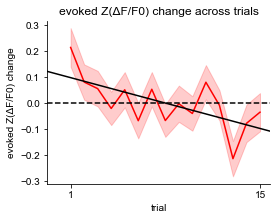

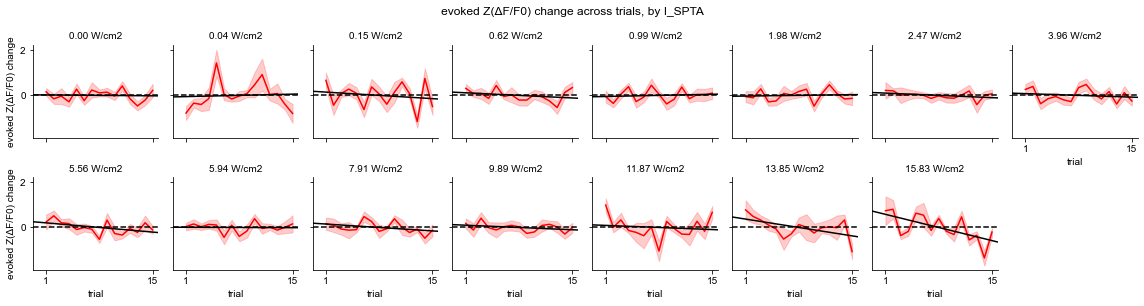

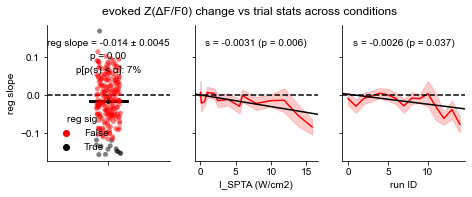

In [39]:
# Set up plotting parameters
trialbounds = zscored_popagg_resp.index.unique(Label.TRIAL).sort_values()[[0, -1]].values
pltkwargs = dict(
    data=zscored_popagg_resp.reset_index(),
    x=Label.TRIAL,
    y=ykey_diff,
    color=Palette.LINE[mouseline],
    errorbar='se',
)

# Plot variation in response strength across trials
figs[f'{ykey_diff} vs trial'], ax = plt.subplots(figsize=(4, 3))
sns.despine(ax=ax)
ax.set_title(f'{ykey_diff} across trials')
sns.lineplot(ax=ax, **pltkwargs)
ax.axhline(0, c='k', ls='--')
ax.set_xticks(trialbounds)

# Add regression line
slope, intercept = zscored_popagg_resp_stats[['reg slope', 'reg intercept']].mean()
ax.axline([0, intercept], slope=slope, c='k')
figs[f'{ykey_diff} vs trial']

# Plot variation in response strength across trials, by ISPTA
colvar = Label.ISPTA
name, unit = parse_label(colvar)
fg = sns.relplot(
    kind='line',
    col=colvar,
    col_wrap=8,
    height=2,
    **pltkwargs
)
fg.set_titles('{col_name:.2f} ' + unit)
fg.refline(y=0, c='k')
for ax in fg.axes.flatten():
    ax.set_xticks(trialbounds)

# Add regression lines
for ax, (col, gdata) in zip(fg.axes.flatten(), zscored_popagg_resp_stats.groupby(colvar)):
    slope, intercept = gdata[['reg slope', 'reg intercept']].mean()
    ax.axline([0, intercept], slope=slope, c='k')
figs[f'{ykey_diff} vs trial by {name}'] = fg.fig
figs[f'{ykey_diff} vs trial by {name}'].suptitle(f'{ykey_diff} across trials, by {name}', y=1.05);

# Compute proportion of slopes that are significantly different from 0
prop_sig_slopes = (zscored_popagg_resp_stats['reg sig']).sum() / len(zscored_popagg_resp_stats)
prop_sig_slopes_str = f'p[p(s) < α]: {prop_sig_slopes * 1e2:.0f}%'

# Plot response vs trial statistics across ISPTA and run order
logger.info(f'computing {ykey_diff} vs {Label.TRIAL} statistics across conditions...')
xkeys = [None, Label.ISPTA, Label.RUNID]
ykeys = [
    'reg slope', 
]
ythrs = {
    'reg slope': 0
}
height = 2.5
figs['resp vs trial stats'], axes = plt.subplots(
    len(ykeys), len(xkeys), 
    figsize=(height * len(xkeys), height * len(ykeys)), 
    sharey='row', sharex='col')
if axes.ndim == 1:
    axes = np.atleast_2d(axes)
figs['resp vs trial stats'].suptitle(f'{ykey_diff} vs {Label.TRIAL} stats across conditions')
for axrow, yk in zip(axes, ykeys):
    if yk == 'cv':
        axrow[0].set_yscale('log')
        axrow[0].set_ylim(8e-1, 2e3)
    elif yk == 'reg pval':
        axrow[0].set_ylim(-0.05, 1.05)
    for ax, xk in zip(axrow, xkeys):
        sns.despine(ax=ax)
        pltkwargs = dict(
            data=zscored_popagg_resp_stats.reset_index(),
            ax=ax,
            y=yk,
            x=xk,
        )
        if xk is None:
            sns.stripplot(
                alpha=0.5,
                # color=Palette.LINE[mouseline],
                hue='reg sig',
                palette={True: 'k', False: Palette.LINE[mouseline]},
                **pltkwargs
            )
            add_mean_and_sem_bars(**pltkwargs, add_text=True)
            if yk == 'reg slope':                
                testres = ttest_1samp(pltkwargs['data'][yk].values, 0.)
                pval_slope_dist = testres.pvalue
                ax.text(
                    .5, .8, f'p = {pval_slope_dist:.2f}', 
                    transform=ax.transAxes, ha='center', va='top')
                ax.text(.5, .7, prop_sig_slopes_str, transform=ax.transAxes, ha='center', va='top')
                sns.move_legend(ax, loc='lower left', frameon=False)
        else:
            sns.lineplot(
                errorbar='se',
                color=Palette.LINE[mouseline],
                **pltkwargs
            )
            add_regression_line(**pltkwargs, robust=True, add_text=True)
        ax.axhline(ythrs[yk], c='k', ls='--')

### Modality of response distributions

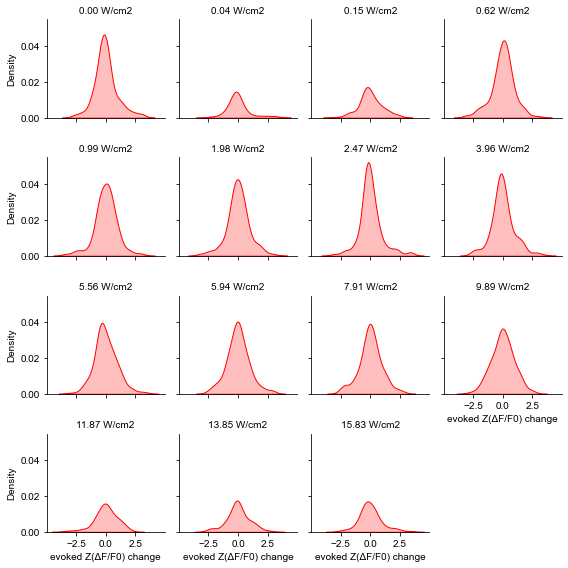

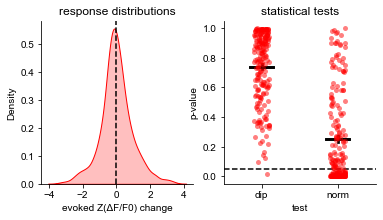

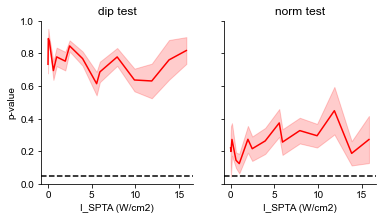

In [40]:
# Plot distribution of z-scored responses, by ISPTA
fg = sns.displot(
    kind='kde',
    data=zscored_popagg_resp.reset_index(),
    x=ykey_diff, 
    color=Palette.LINE[mouseline],
    fill=True,
    col=Label.ISPTA,
    col_wrap=4,
    height=2,
)
name, unit = parse_label(Label.ISPTA)
fg.set_titles('{col_name:.2f} ' + unit)
figs['resp distributions by ISPTA'] = fg.fig

# Create figure
figs['resp distributions'], axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot distribution of z-scored responses
ax = axes[0]
sns.despine(ax=ax)
ax.set_title('response distributions')
ax.axvline(0, c='k', ls='--')
sns.kdeplot(
    ax=ax,
    data=zscored_popagg_resp.reset_index(),
    x=ykey_diff, 
    color=Palette.LINE[mouseline],
    fill=True,
)

# Extract pvalues for unmodiality and normality tests
testkeys = ['dip', 'norm']
distpvals = zscored_popagg_resp_stats[[f'{k} pval' for k in testkeys]]
distpvals.columns = distpvals.columns.str.replace(' pval', '')
distpvals = distpvals.stack().rename('p-value')
distpvals.index.set_names('test', level=len(distpvals.index.names) - 1, inplace=True)

# Plot p-values distributions for each performed test
ax = axes[1]
ax.set_title('statistical tests')
sns.despine(ax=ax)
pltkwargs = dict(
    ax=ax,
    data=distpvals.reset_index(),
    x='test',
    y='p-value',
)
sns.stripplot(**pltkwargs, color=Palette.LINE[mouseline], alpha=0.5)
add_mean_and_sem_bars(**pltkwargs)
ax.axhline(PTHR_DETECTION, c='k', ls='--')

# Plot p-values vs ispta profiles for distirbution unimodality and normality tests
figs['dist pvals vs ispta'], axes = plt.subplots(1, len(testkeys), sharey=True, figsize=(3 * len(testkeys), 3))
for ax, k in zip(axes, testkeys):
    sns.despine(ax=ax)
    sns.lineplot(
        ax=ax,
        data=zscored_popagg_resp_stats,
        x=Label.ISPTA,
        y=f'{k} pval',
        color=Palette.LINE[mouseline],
        errorbar='se',
    )
    ax.axhline(PTHR_DETECTION, c='k', ls='--')
    ax.set_title(f'{k} test')
axes[0].set_ylim(0, 1)
axes[0].set_ylabel('p-value');

### State-dependence of evoked activity

 2024/04/05 15:18:29: computing ['pre-stim avg Z(ΔF/F0)', 'evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
 2024/04/05 15:18:30: computing ['baseline pre-stim avg Z(ΔF/F0)', 'baseline evoked Z(ΔF/F0) change'] pairwise correlation coefficients...
 2024/04/05 15:18:30: rendering hist-plot of evoked Z(ΔF/F0) change vs. pre-stim avg Z(ΔF/F0)...
 2024/04/05 15:18:31: rendering hist-plot of baseline evoked Z(ΔF/F0) change vs. baseline pre-stim avg Z(ΔF/F0)...
 2024/04/05 15:18:32: plotting comparative distribution of correlation coefficients...
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

stimulus vs. baseline: t-test paired samples, P_val:4.321e-02 t=2.035e+00
 2024/04/05 15:18:32: plotting average correlation coefficient vs ISPTA for stim window...


/var/folders/86/b3z067_j0sbfgbhl7gx4p5640000gn/T/ipykernel_52078/3939869321.py:101: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax, **pltkwargs, palette=cdict, alpha=0.5)
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/opt/anaconda3/envs/usnm2p/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


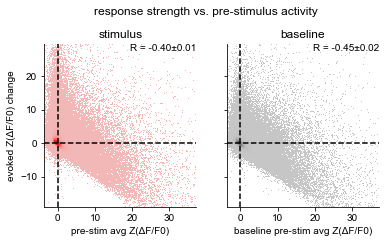

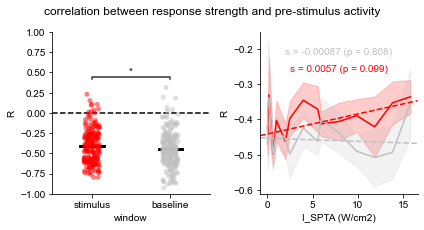

In [112]:
# Define variable of interest
ykey = Label.ZSCORE

# Extract pre, post and change keys
ykey_prestim, ykey_poststim, ykey_change = get_change_key(ykey, full_output=True)

# Define keys of variables to correlate / regress
xykeys = [ykey_prestim, ykey_change]

# Define prefix and color for each window of interest
prefixes = {
    'stimulus': '', 
    'baseline': 'baseline '
}
cdict = {
    'stimulus': Palette.LINE[get_singleton(trialagg_stats, Label.LINE)],
    'baseline': 'silver'
}

# Initialize dict of correlation coefficients
corrcoeffs = {}

# Define input data and grouping categories for correlation computation
corr_input_data = valid_stats.copy()
gby = [
    Label.DATASET,
    Label.ISPTA
]

# Define quantile bounds for response strength plots
qmargin = 0.001
qbounds = [qmargin, 1 - qmargin]

# Initialize limits for response strength plots
xmin, xmax = np.inf, -np.inf
ymin, ymax = np.inf, -np.inf

# For each analysis window
for wtype, prefix in prefixes.items():
    # Extract prefix and associated XY keys
    wkeys = [f'{prefix}{k}' for k in xykeys]

    # Compute Pearson correlation coefficient between pre- average and evoked change
    logger.info(f'computing {wkeys} pairwise correlation coefficients...')
    corrcoeffs[wtype] = (corr_input_data
        .groupby(gby)
        [wkeys]
        .corr()
        .droplevel(-1)
        .iloc[::2, 1]
        .rename('R')
    )

    # Refine limits for response strength plots
    xbounds, ybounds = corr_input_data[wkeys].quantile(qbounds).values.T
    xmin, xmax = min(xmin, xbounds[0]), max(xmax, xbounds[1])
    ymin, ymax = min(ymin, ybounds[0]), max(ymax, ybounds[1])

# Convert correlation coefficients to dataframe
corrcoeffs = pd.concat(corrcoeffs, axis=0, keys=corrcoeffs.keys(), names=['window'])

# Compute average and standard error of correlation coefficients per window type
rstats = corrcoeffs.groupby('window').agg(['mean', 'sem'])

# Plot pre vs evoked change distributions for each window type
figs['prepost codists'], axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
figs['prepost codists'].suptitle('response strength vs. pre-stimulus activity', y=1.05)
for ax, (wtype, prefix) in zip(axes, prefixes.items()):
    # Extract prefix and associated XY keys
    wkeys = [f'{prefix}{k}' for k in xykeys]

    # Plot co-distribution of pre and evoked change
    plot_codistribution(
        corr_input_data,
        *wkeys,
        ax=ax,
        color=cdict[wtype],
    )
    ax.set_title(wtype)

    # Annotate average correlation coefficient
    ax.text(1, 1, f'R = {rstats.loc[wtype, "mean"]:.2f}±{rstats.loc[wtype, "sem"]:.2f}', 
            transform=ax.transAxes, ha='right', va='top')

# Set common axis limits
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

# Create figure
figs['prepost corr'], axes = plt.subplots(1, 2, figsize=(6, 3))#, sharey=True)

# Plot comparative distribution of correlation coefficients stim-evoked vs baseline
logger.info('plotting comparative distribution of correlation coefficients...')
ax = axes[0]
sns.despine(ax=ax)
pltkwargs = dict(
    data=corrcoeffs.reset_index(),
    x='window',
    y='R',
)
sns.stripplot(ax=ax, **pltkwargs, palette=cdict, alpha=0.5)
add_mean_and_sem_bars(ax=ax, **pltkwargs)

# Add statistical comparison between original and transformed data
annotator = Annotator(ax, [tuple(cdict.keys())], **pltkwargs)
annotator.configure(test='t-test_paired', loc='outside')
annotator.apply_and_annotate()
ax.set_ylim(-1, 1)
ax.axhline(0, ls='--', c='k')

# Plot ISPTA dependency of pre- vs evoked correlation coefficients for stimulus case
logger.info(f'plotting average correlation coefficient vs ISPTA for stim window...')
ax = axes[1]
sns.despine(ax=ax)

# # Add reference line for baseline correlation
# bstats = rstats.loc['baseline']
# ax.axhline(bstats['mean'], c=cdict['baseline'])
# ax.axhspan(bstats['mean'] - bstats['sem'], bstats['mean'] + bstats['sem'], color=cdict['baseline'], alpha=0.5)

# Plot correlation coefficients vs ISPTA for stimulus window
pltkwargs = dict(
    ax=ax,
    x=Label.ISPTA,
    y='R',
    hue='window',
    legend=False,
    palette=cdict,
)
sns.lineplot(data=corrcoeffs.reset_index(), **pltkwargs, errorbar='se')

# Add regression line
if Label.ROI not in gby:
    ytxt = 0.9
    for kind, gdata in corrcoeffs.groupby('window'):
        add_regression_line(
            data=gdata,
            color=cdict[kind],
            **pltkwargs,
            robust=True,
            add_text=True,
            ytxt=ytxt,
            ls='--',
        )
        ytxt -= .1

# ax.axhline(0, ls='--', c='k', zorder=-1)
figs['prepost corr'].tight_layout()
figs['prepost corr'].suptitle('correlation between response strength and pre-stimulus activity', y=1.05);

 2024/04/05 17:15:29: building predictive model of change vs pre activity in baseline interval across ['dataset'] ...


17it [00:03,  4.27it/s]                        

 2024/04/05 17:15:33: expanding (17 datasets) input dataframe to match (17 datasets x 1145 ROIs x 15 runs x 15 trials) reference dataframe


 2024/04/05 17:15:36: regression results:
      intercept     slope  pval        r2
mean  -0.016951 -0.491963   0.0  0.134087
sem    0.014494  0.014613   0.0  0.015320
 2024/04/05 17:15:36: predicting evoked change from pre activity in stimulus interval...
 2024/04/05 17:15:36: computing correlation between residuals and pre activity...


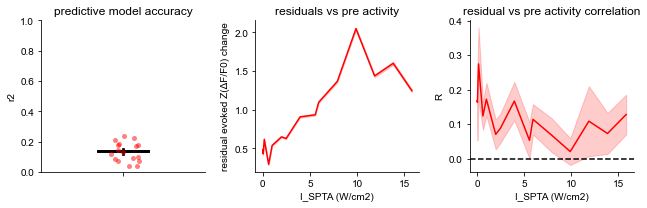

In [185]:
# # Determine grouping variables
# gby = [
#     Label.DATASET,
#     # Label.ROI,
#     # Label.ISPTA,
# ]

# # Extract response keys
# ykey_pre, ykey_post, ykey_change = get_change_key(ykey, full_output=True)

# # Build auto-correlation model of change vs pre activity in baseline interval
# logger.info(f'building predictive model of change vs pre activity in baseline interval across {gby} ...')
# wkeys = [f'baseline {k}' for k in [ykey_prestim, ykey_change]]
# regkwargs = dict(
#     xkey=wkeys[0], 
#     ykey=wkeys[1], 
#     robust=True
# )
# if gby:
#     groups = corr_input_data.groupby(gby)
#     with tqdm(total=groups.ngroups - 1, position=0, leave=True) as pbar:
#         regres = groups.apply(pbar_update(
#             lambda x: apply_linregress(x, **regkwargs), pbar))
#     expregres = free_expand(regres, corr_input_data)
#     aggregres = regres.agg(['mean', 'sem'])
# else:
#     regres = apply_linregress(corr_input_data, **regkwargs)
#     expregres = pd.DataFrame(index=corr_input_data.index)
#     for k, v in regres.items():
#         expregres[k] = v

# logger.info(f'regression results:\n{aggregres}')

# # Apply model to predict change from pre activity in stimulus interval
# logger.info('predicting evoked change from pre activity in stimulus interval...')
# corr_input_data[f'predicted {ykey_change}'] = expregres['slope'] * corr_input_data[ykey_prestim] + expregres['intercept']
# # Compute residuals between expected vs. measured change and add to stats
# corr_input_data[f'residual {ykey_change}'] = corr_input_data[ykey_change] - corr_input_data[f'predicted {ykey_change}']

# # Determine grouping variables
# gby = [
#     Label.DATASET,
#     # Label.ROI,
#     Label.ISPTA
# ]

# # Compute correlation between residuals and pre activity
# logger.info('computing correlation between residuals and pre activity...')
# corrcoeff = (corr_input_data
#     .groupby(gby)
#     [[ykey_prestim, f'residual {ykey_change}']]
#     .corr()
#     .droplevel(-1)
#     .iloc[::2, 1]
#     .rename('R')
# )

# # Create figure
# fig, axes = plt.subplots(1, 3, figsize=(9, 3))
# for ax in axes:
#     sns.despine(ax=ax)
# axiter = iter(axes)

# # Plot predictive model accuracy
# ax = next(axiter)
# ax.set_title('predictive model accuracy')
# ax.set_ylim(0, 1)
# pltkwargs = dict(
#     ax=ax, 
#     data=regres, 
#     y='r2',
# )
# if isinstance(regres, pd.DataFrame):
#     sns.stripplot(**pltkwargs, color=Palette.LINE[mouseline], alpha=0.5)
#     add_mean_and_sem_bars(**pltkwargs)
# else:
#     ax.bar([0], [regres['r2']],  color=Palette.LINE[mouseline])
#     ax.set_xlim(-1, 1)
#     ax.set_xticks([])
#     ax.set_ylabel('r2')

# # Plot residuals vs ISPTA
# ax = next(axiter)
# ax.set_title('residuals vs pre activity')
# sns.lineplot(
#     ax=ax,
#     data=corr_input_data,
#     x=Label.ISPTA,
#     y=f'residual {ykey_change}',
#     color=Palette.LINE[mouseline],
#     errorbar='se',
# )

# # Plot residuals vs pre activity correlation vs ISPTA
# ax = next(axiter)
# ax.set_title('residual vs pre activity correlation')
# sns.lineplot(
#     ax=ax,
#     data=corrcoeff.reset_index(),
#     x=Label.ISPTA,
#     y='R',
#     color=Palette.LINE[mouseline],
#     errorbar='se',
# )
# ax.axhline(0, c='k', ls='--')

# fig.tight_layout()

## Exports

### Save responder-type-averaged stats to disk

In [34]:
# Define resp prop extraction function
respprops_func = lambda df: get_responders_counts(
    df, Label.RUN, units=Label.DATASET, normalize=True)

# Get resp fractions by dataset, run and responder type
resp_props_by_type = trialagg_stats.groupby(Label.ROI_RESP_TYPE).apply(respprops_func)
weights = resp_props_by_type.pop('weight')
weighted_resp_props = resp_props_by_type.multiply(weights, axis=0).groupby([Label.ROI_RESP_TYPE, Label.RUN]).sum()
resp_props_sem = resp_props_by_type.groupby([Label.ROI_RESP_TYPE, Label.RUN]).sem()
resp_frac_by_type = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Get overall resp fractions by dataset and run
resp_props_all = respprops_func(trialagg_stats)
weights = resp_props_all.pop('weight')
weighted_resp_props = resp_props_all.multiply(weights, axis=0).groupby(Label.RUN).sum()
resp_props_sem = resp_props_all.groupby(Label.RUN).sem()
resp_frac_all = pd.concat([
    weighted_resp_props['positive'].rename('mean'),
    resp_props_sem['positive'].rename('sem')
], axis=1)

# Merge the two datasets
resp_frac_stats = (
    pd.concat([
        resp_frac_by_type, 
        resp_frac_all
            .assign(**{Label.ROI_RESP_TYPE: 'all'})
            .set_index(Label.ROI_RESP_TYPE, append=True)
            .reorder_levels([Label.ROI_RESP_TYPE, Label.RUN])
    ], axis=0)
    .add_prefix(f'{Label.RESP_FRAC} - ')
)

# Extract output directory for line-aggregated data
lineagg_dir = get_output_equivalent(
    os.path.split(input_dir)[0], DataRoot.PROCESSED, DataRoot.LINESTATS)

# For each error propagation type
for errprop in ['intra', 'inter']:
    # Determine output file path
    fpath = os.path.join(lineagg_dir, f'{mouseline}_{errprop}.csv')
    # Extract line-aggregated data
    lineagg_stats = get_crossdataset_average(
        trialagg_stats, Label.RUN, hue=Label.ROI_RESP_TYPE, errprop=errprop, add_global_avg=True)
    # Add information about responder types
    lineagg_stats = pd.concat([lineagg_stats, resp_frac_stats], axis=1)
    logger.info(f'saving line-aggregated stats to {fpath}...')
    lineagg_stats.to_csv(fpath)

# Add information about cell count per dataset
nROIs_per_dataset = (get_detailed_ROI_count(trialagg_stats)
    .max(axis=1)
    .astype(int)
    .rename(Label.ROI_COUNT)
    .to_frame()
    .assign(line=mouseline)
    .set_index(Label.LINE, append=True)
)
fpath = os.path.join(lineagg_dir, f'{mouseline}_counts.csv')
nROIs_per_dataset.to_csv(fpath)

 2024/04/03 13:22:26: run not part of (P (MPa), DC (%)) -> no filtering
 2024/04/03 13:22:26: run not part of (P (MPa), DC (%)) -> no filtering
 2024/04/03 13:22:26: run not part of (P (MPa), DC (%)) -> no filtering
 2024/04/03 13:22:26: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) dataframe across run...
 2024/04/03 13:22:27: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) dataframe across run...
 2024/04/03 13:22:27: saving line-aggregated stats to /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq30.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main/sst_intra.csv...
 2024/04/03 13:22:27: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) dataframe across run...
 2024/04/03 13:22:27: computing ROI-weighted average of (17 datasets x 1145 ROIs x 15 runs) dataframe across run...
 2024/04/03 13:22:27: saving line-aggregated stats to /User

### Save figures

In [35]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 2024/04/03 13:22:27: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2024.04.03/figs_main_sst_k0.5_alpha0.7_qadaptive_wq30.0s_aggmedian_classzscore_directional.pdf:


  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:07<00:00,  4.05it/s]


### Notify upon completion

In [36]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'{mouseline} batch notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2024/04/03 13:22:35: sst batch notebook completed in 0:07:44.230963 s
